
# Week 3 - Discovering higher-level Patterns (Topic Modeling & Clustering)

The first 2 weeks have primarily used the word count of documents as their measure, such as counting the number of "positive" and "negative" words to determine sentiment.

This week, we learn a second kind of document representation in clusters or topics. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [16]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
# !pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian).

In [17]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [18]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [19]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=('headers', 'footers', 'quotes'), data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware


Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


text               category  \
0  \tIn certain Apple 13" RGB monitors there has ...  comp.sys.mac.hardware   
1  Does anyone know how to reach Micron?  I am in...  comp.sys.mac.hardware   
2  Hi there!\n\nCould some kind soul tell me what...  comp.sys.mac.hardware   
3                                        "auto\nfrom  comp.sys.mac.hardware   
4  \n\n    Don't believe the hype. There is no su...  comp.sys.mac.hardware   
5  What is the value of an SE (HDFD) 4/20?\n\n-David  comp.sys.mac.hardware   
6  \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...  comp.sys.mac.hardware   
7  \n\n\n    Nope. The Apple 16" monitor does not...  comp.sys.mac.hardware   
8  \n\nIs it a hidden option?  I'm using PowerStr...  comp.sys.mac.hardware   
9  \n\n\nThe previous article referred to the fac...  comp.sys.mac.hardware   

                                         source_file  
0  ../data/scikit_learn_data/20news_home/20news-b...  
1  ../data/scikit_learn_data/20news_home/20news-b...  
2  ../data/scikit_learn_data/20news_home/20news-b...  
3  ../data/scikit_learn_data/20news_home/20news-b...  
4  ../data/scikit_learn_data/20news_home/20news-b...  
5  ../data/scikit_learn_data/20news_home/20news-b...  
6  ../data/scikit_learn_data/20news_home/20news-b...  
7  ../data/scikit_learn_data/20news_home/20news-b...  
8  ../data/scikit_learn_data/20news_home/20news-b...  
9  ../data/scikit_learn_data/20news_home/20news-b...

Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [20]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


I'm pretty sure that you're very familiar with the cell above now, but let's go through the concepts again.

What do we want to do here? We want to do vectorization, i.e., converting texts into numerical features (vectors) as required by machine learning algorithms. And this is what feature_extraction module does: to extract features from texts in a format as required by ML algorithms. feature_extraction module has four classes: CountVectorizer, DictVectorizer, TfidfVectorizer, and FeatureHasher. Here, we use CountVectorizer, but we'll also use TfidfVectorizer as well below.

There are various strategies by which we extract features. Here, we use CountVectorizer, and, in particular, we use 'Bag of Words' representation. In other words, the features we hope to extract from the texts are each individual token occurrence frequency. We simply count the the occurrence of each token in each document. So, here, we get a document-term-matrix, in which documents are characterized by the occurrences of tokens. Other forms of features, such as the relative position information of words, are ignored. We'll see other types of representations and strategies as well soon, such as N-gram (by the way, we can do n-gram with CountVectorizer. CountVectorizer class takes a set of parameters, such as analyzer, which you can specify the n-gram).

the first line of the cell above instantiate a class, CountVectorizer(). In other words, you created an instance, or realization of a class. What is a class and what does instantiation mean? That's a long story, maybe for next time.

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [21]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [22]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

What is the toarray() function here? It's similar to todense()--todense() and toarray() both returns a dense representation of a matrix; however, todense() returns a matrix representation while toarray() returns a ndarray representation.

We can also lookup the indices of different words using the Vectorizer

In [23]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [24]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [25]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

Let's see what we're doing here. First, you need to know what vocabulary\_ does. vocabulary\_ is an attribute of the CountVectorizer, which gives you a mapping of terms to feature indices. It gives you all the terms and their feature indices, so it's a dictionary. So, by doing "ngCountVectorizer.vocabulary\_.keys()", we get the keys of the dictionary, which are the terms.

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [26]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [27]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [28]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [29]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [30]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [31]:
km.fit(newsgroupsTFVects)

KMeans(n_clusters=4)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*.

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup).

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [32]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'DetCurveDisplay', 'DistanceMetric', 'PrecisionRecallDisplay', 'PredictionErrorDisplay', 'RocCurveDisplay', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'class_likelihood_ratios', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'd2_absolute_error_score', 'd2_pinball_score', 'd2_tweedie_score', 'davies_bouldin_score', 'dcg_score', 'det_curve', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'get_scorer_names', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_err

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [33]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

text  \
0     \tIn certain Apple 13" RGB monitors there has ...   
1     Does anyone know how to reach Micron?  I am in...   
2     Hi there!\n\nCould some kind soul tell me what...   
3                                           "auto\nfrom   
4     \n\n    Don't believe the hype. There is no su...   
...                                                 ...   
2345  I was wondering if anyone out in net-land have...   
2346  \n\n\n\n\nI sold my '86 Sprint last April with...   
2347  Actually I wasn't too surprised, since I bough...   
2348  \n\nI couldnt agree more.  That is how it SHOU...   
2349  \nWarren Brown, the Washington Post's auto wri...   

                   category  \
0     comp.sys.mac.hardware   
1     comp.sys.mac.hardware   
2     comp.sys.mac.hardware   
3     comp.sys.mac.hardware   
4     comp.sys.mac.hardware   
...                     ...   
2345              rec.autos   
2346              rec.autos   
2347              rec.autos   
2348              rec.autos   
2349              rec.autos   

                                            source_file  kmeans_predictions  
0     ../data/scikit_learn_data/20news_home/20news-b...                   2  
1     ../data/scikit_learn_data/20news_home/20news-b...                   2  
2     ../data/scikit_learn_data/20news_home/20news-b...                   2  
3     ../data/scikit_learn_data/20news_home/20news-b...                   2  
4     ../data/scikit_learn_data/20news_home/20news-b...                   2  
...                                                 ...                 ...  
2345  ../data/scikit_learn_data/20news_home/20news-b...                   2  
2346  ../data/scikit_learn_data/20news_home/20news-b...                   0  
2347  ../data/scikit_learn_data/20news_home/20news-b...                   0  
2348  ../data/scikit_learn_data/20news_home/20news-b...                   2  
2349  ../data/scikit_learn_data/20news_home/20news-b...                   2  

[2350 rows x 4 columns]

We can also look at the distinguishing features in each cluster:

In [34]:
terms = ngTFVectorizer.get_feature_names_out()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 car
 cars
 engine
 like
 just
 good
 think
 don
 oil
 dealer


Cluster 1:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 interested
 price
 email


Cluster 2:
 know
 thanks
 mac
 just
 does
 like
 drive
 apple
 don
 new


Cluster 3:
 window
 server
 use
 motif
 using
 widget
 program
 application
 code
 like




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [35]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [36]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [37]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

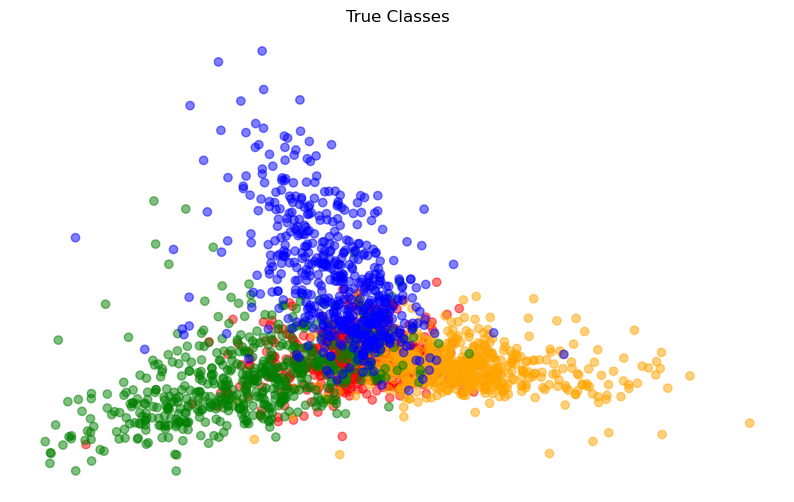

In [38]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

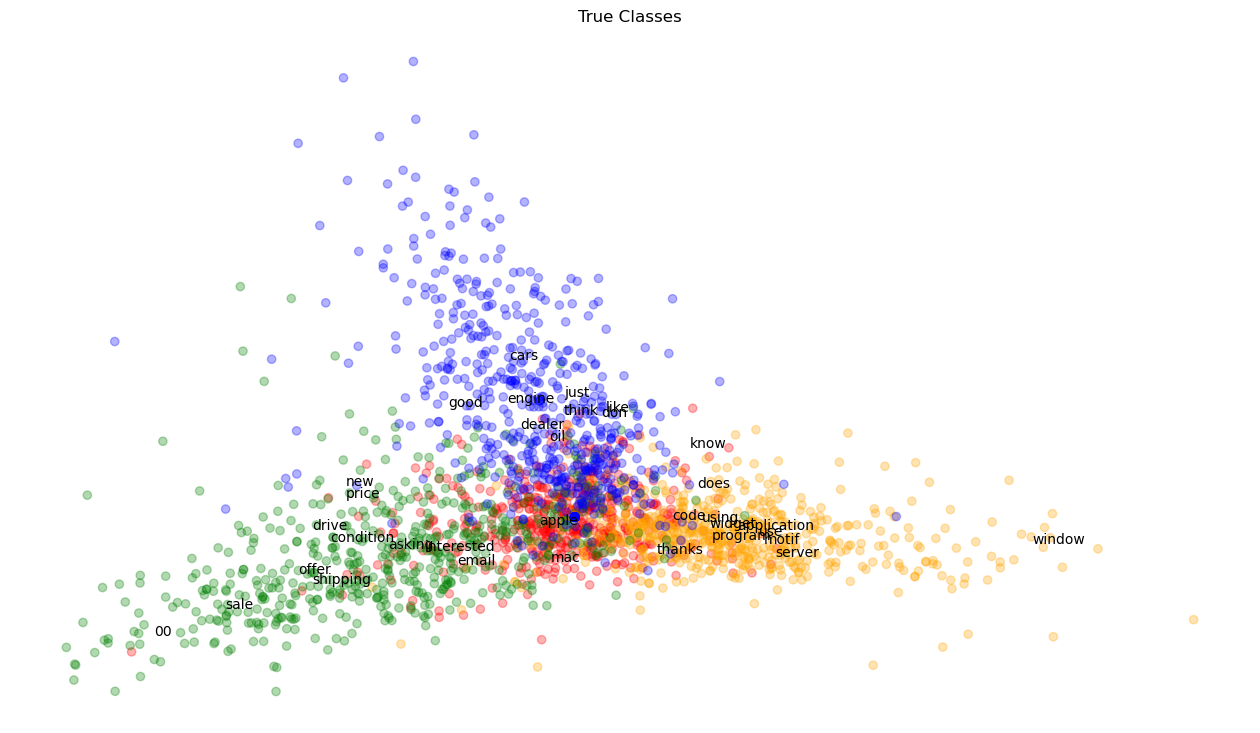

In [39]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [40]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]
colors_p[:10]

['green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green']

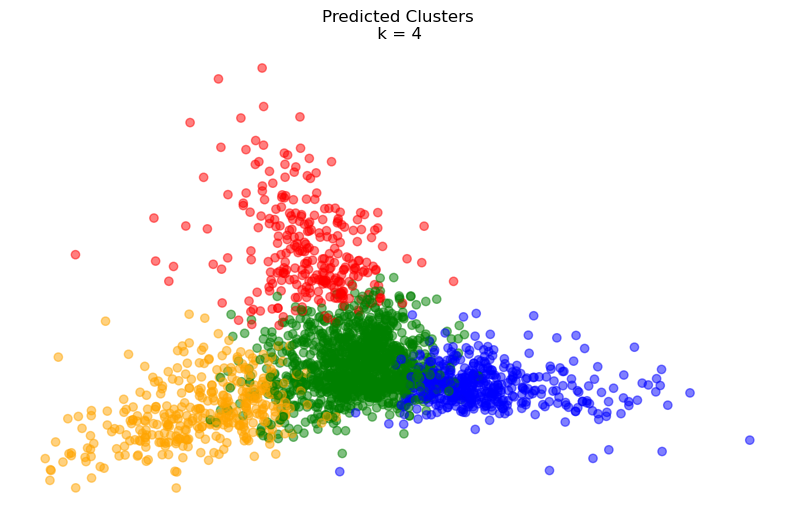

In [41]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [42]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(n_clusters=3)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [43]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

In [44]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

/var/folders/4j/0fgh8w_10_z5wv518j7l299h0000gn/T/ipykernel_48326/1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


For n_clusters = 3, The average silhouette_score is : 0.012


In [45]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

/var/folders/4j/0fgh8w_10_z5wv518j7l299h0000gn/T/ipykernel_48326/1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


For n_clusters = 4, The average silhouette_score is : 0.012


In [46]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

/var/folders/4j/0fgh8w_10_z5wv518j7l299h0000gn/T/ipykernel_48326/1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


For n_clusters = 5, The average silhouette_score is : 0.012


/var/folders/4j/0fgh8w_10_z5wv518j7l299h0000gn/T/ipykernel_48326/1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


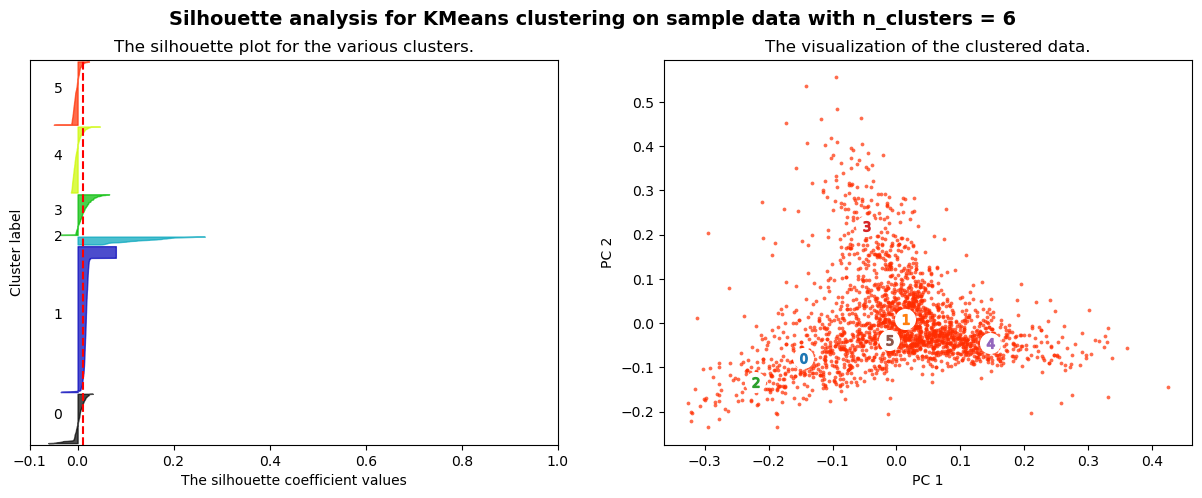

For n_clusters = 6, The average silhouette_score is : 0.012


In [47]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [48]:
targetSenator = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']

#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

for senator in targetSenator:
    print("Fetching {}'s data".format(senator))
    targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(senator), maxFiles = 2000)
    targetDF['targetSenator'] = senator
    senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

Fetching Voinovich's data
Fetching Obama's data
Fetching Whitehouse's data
Fetching Snowe's data
Fetching Rockefeller's data
Fetching Murkowski's data
Fetching McCain's data
Fetching Kyl's data
Fetching Baucus's data
Fetching Frist's data


In [49]:
#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("../data/senReleasesTraining.csv")

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

Unnamed: 0                       name  \
0           0    10Apr2008Voinovich3.txt   
1           1    10Apr2008Voinovich4.txt   
2           2  10Aug2006Voinovich169.txt   
3           3  10Jan2006Voinovich238.txt   
4           4  10Jan2007Voinovich141.txt   

                                                text  \
0  SEN. VOINOVICH SECURES ASSISTANCE FOR STRUGGLI...   
1  SEN. VOINOVICH INTRODUCES STRENGTHENED BEACH P...   
2  SEN. VOINOVICH STATEMENT ON FOILED TERROR PLOT...   
3  SEN. VOINOVICH SECURES $1.8 MILLION FOR HEALTH...   
4  SEN. VOINOVICH ISSUES STATEMENT ON NEW DIRECTI...   

                                      path  \
0    raw/Voinovich/10Apr2008Voinovich3.txt   
1    raw/Voinovich/10Apr2008Voinovich4.txt   
2  raw/Voinovich/10Aug2006Voinovich169.txt   
3  raw/Voinovich/10Jan2006Voinovich238.txt   
4  raw/Voinovich/10Jan2007Voinovich141.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url targetSenator  
0  https://raw.githubusercontent.com/lintool/Grim...     Voinovich  
1  https://raw.githubusercontent.com/lintool/Grim...     Voinovich  
2  https://raw.githubusercontent.com/lintool/Grim...     Voinovich  
3  https://raw.githubusercontent.com/lintool/Grim...     Voinovich  
4  https://raw.githubusercontent.com/lintool/Grim...     Voinovich

Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [50]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [51]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [52]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [53]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [54]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(n_clusters=3)

And visualize:

In [55]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

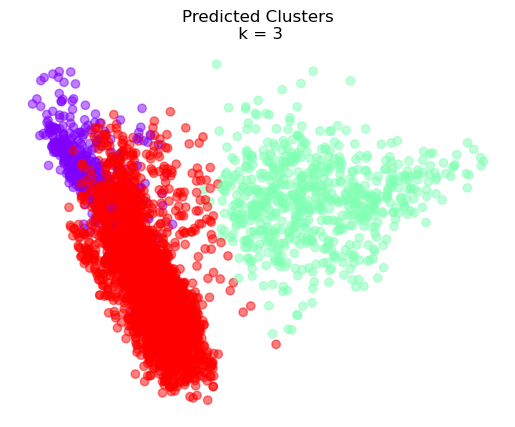

In [56]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [57]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

Unnamed: 0                       name  \
0              0    10Apr2008Voinovich3.txt   
1              1    10Apr2008Voinovich4.txt   
2              2  10Aug2006Voinovich169.txt   
3              3  10Jan2006Voinovich238.txt   
4              4  10Jan2007Voinovich141.txt   
...          ...                        ...   
4800        4800       9Sep2004Frist332.txt   
4801        4801       9Sep2004Frist333.txt   
4802        4802       9Sep2004Frist334.txt   
4803        4803       9Sep2004Frist335.txt   
4804        4804       9Sep2004Frist336.txt   

                                                   text  \
0     SEN. VOINOVICH SECURES ASSISTANCE FOR STRUGGLI...   
1     SEN. VOINOVICH INTRODUCES STRENGTHENED BEACH P...   
2     SEN. VOINOVICH STATEMENT ON FOILED TERROR PLOT...   
3     SEN. VOINOVICH SECURES $1.8 MILLION FOR HEALTH...   
4     SEN. VOINOVICH ISSUES STATEMENT ON NEW DIRECTI...   
...                                                 ...   
4800  SEN. FRIST COMMENTS ON INTELLIGENCE REFORM\n  ...   
4801  SEN. FRIST URGES SUPPORT FOR SALES TAX DEDUCTI...   
4802  SEN. FRIST WAGES SUPPORT FOR STATE SALES TAX D...   
4803  TENNESSEE GETS $4.8 MILLION IN FEDERAL FUNDS T...   
4804  SEN. FRIST APPLAUDS ADMINISTRATION'S FINDINGS ...   

                                         path  \
0       raw/Voinovich/10Apr2008Voinovich3.txt   
1       raw/Voinovich/10Apr2008Voinovich4.txt   
2     raw/Voinovich/10Aug2006Voinovich169.txt   
3     raw/Voinovich/10Jan2006Voinovich238.txt   
4     raw/Voinovich/10Jan2007Voinovich141.txt   
...                                       ...   
4800           raw/Frist/9Sep2004Frist332.txt   
4801           raw/Frist/9Sep2004Frist333.txt   
4802           raw/Frist/9Sep2004Frist334.txt   
4803           raw/Frist/9Sep2004Frist335.txt   
4804           raw/Frist/9Sep2004Frist336.txt   

                                               html_url  \
0     https://github.com/lintool/GrimmerSenatePressR...   
1     https://github.com/lintool/GrimmerSenatePressR...   
2     https://github.com/lintool/GrimmerSenatePressR...   
3     https://github.com/lintool/GrimmerSenatePressR...   
4     https://github.com/lintool/GrimmerSenatePressR...   
...                                                 ...   
4800  https://github.com/lintool/GrimmerSenatePressR...   
4801  https://github.com/lintool/GrimmerSenatePressR...   
4802  https://github.com/lintool/GrimmerSenatePressR...   
4803  https://github.com/lintool/GrimmerSenatePressR...   
4804  https://github.com/lintool/GrimmerSenatePressR...   

                                           download_url targetSenator  \
0     https://raw.githubusercontent.com/lintool/Grim...     Voinovich   
1     https://raw.githubusercontent.com/lintool/Grim...     Voinovich   
2     https://raw.githubusercontent.com/lintool/Grim...     Voinovich   
3     https://raw.githubusercontent.com/lintool/Grim...     Voinovich   
4     https://raw.githubusercontent.com/lintool/Grim...     Voinovich   
...                                                 ...           ...   
4800  https://raw.githubusercontent.com/lintool/Grim...         Frist   
4801  https://raw.githubusercontent.com/lintool/Grim...         Frist   
4802  https://raw.githubusercontent.com/lintool/Grim...         Frist   
4803  https://raw.githubusercontent.com/lintool/Grim...         Frist   
4804  https://raw.githubusercontent.com/lintool/Grim...         Frist   

      kmeans_predictions  
0                      2  
1                      2  
2                      2  
3                      2  
4                      2  
...                  ...  
4800                   2  
4801                   2  
4802                   2  
4803                   2  
4804                   2  

[4805 rows x 8 columns]

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora?

Retrieve the data:

In [58]:
# The S2 API Key used to fetch articles
api_key = 'KOyXiGdu4t38zFJFFyuKF5jQGBGdxCSfDICseepg'
headers = {"x-api-key": api_key}

In [59]:
import time
import requests
import random

def scrape_abstract(fieldsOfStudy, limit_per_field=600, 
                    url='https://api.semanticscholar.org/graph/v1/paper/search'):

    headers = {"x-api-key": "KOyXiGdu4t38zFJFFyuKF5jQGBGdxCSfDICseepg"}
    
    all_data = []

    # Start with no offset
    offset = 0
    total_papers = 0

    while total_papers < limit_per_field:
        query_params = {
            'query': fieldsOfStudy,
            'fields': 'title,authors,abstract',
            'limit': 100,  # This is typically the max the API allows per request
            'offset': offset
        }

        response = requests.get(url, headers=headers, params=query_params)

        if response.status_code == 200:
            papers = response.json().get('data', [])
            
            # Break the loop if no papers are returned
            if not papers:
                break

            for paper in papers:
                title = paper.get('title')
                author = paper.get('authors')
                abstract = paper.get('abstract')

                if not title or not author or not abstract:
                    continue

                author_names = ', '.join([a['name'] for a in author])

                all_data.append({
                    "FieldOfStudy": fieldsOfStudy,
                    "Title": title,
                    "Author": author_names,
                    "Abstract": abstract})

                total_papers += 1

                # Break the loop if we have reached the limit
                if total_papers >= limit_per_field:
                    break

        else:
            print(f"Request failed with status code {response.status_code}")
            break

        # Increase the offset for the next loop iteration
        offset += len(papers)

        # Sleep to respect rate limits
        sleep_time = random.randint(1,3)
        time.sleep(sleep_time)

    df = pandas.DataFrame(all_data)

    return df

In [60]:
fieldsOfStudy = ["Sociology", "Psychology", "Economics", "Chemistry", "Biology", "Medicine"]

In [123]:
abstract_corpus = pandas.DataFrame()
for f in fieldsOfStudy:
    abstract = scrape_abstract(f)
    abstract_corpus = abstract_corpus.append(abstract, ignore_index = True)

Request failed with status code 400


In [124]:
abstract_corpus

FieldOfStudy                                              Title  \
0       Sociology  Handbook of Theory and Research for the Sociol...   
1       Sociology  Social Capital: Its Origins and Applications i...   
2       Sociology  Some Elements of a Sociology of Translation: D...   
3       Sociology                             Sociology of Childhood   
4       Sociology    Outsiders Studies in the Sociology of Deviance.   
...           ...                                                ...   
3553     Medicine        Acupuncture: Theory, Efficacy, and Practice   
3554     Medicine  Guidelines for preventing and treating vitamin...   
3555     Medicine               Veterinary Medicine and Human Health   
3556     Medicine  A preliminary investigation of balint and non-...   
3557     Medicine  Pyelonephritis and bacteriuria. A major proble...   

                                                 Author  \
0                                         J. Richardson   
1                                             A. Portes   
2                                             M. Callon   
3                                         S. Grieshaber   
4                                             B. Werble   
...                                                 ...   
3553                                        T. Kaptchuk   
3554  M. Holick, N. Binkley, H. Bischoff-Ferrari, C....   
3555                                       W. H. Wright   
3556                        A. L. Turner, Ronald L Malm   
3557                                            E. Kass   

                                               Abstract  
0     The first of its kind, this handbook synthesiz...  
1     This paper reviews the origins and definitions...  
2     This paper outlines a new approach to the stud...  
3     The sociology of childhood has been used incre...  
4     This 1966 paperback edition of a publication w...  
...                                                 ...  
3553  Acupuncture is an important therapy in East As...  
3554  Boston University School of Medicine (M.F.H.),...  
3555  According to the preface, this work is designe...  
3556  BACKGROUND AND OBJECTIVES\nDespite inclusion o...  
3557  THE CHANGING PATTERN of infectious disease is ...  

[3558 rows x 4 columns]

For the k-means clustering, I focus on the title of extracted papers.

Cluster using K-means:

In [63]:
targetDF = abstract_corpus
textColumn = 'Title'
numCategories = len(set(abstract_corpus['FieldOfStudy']))

In [64]:
# Tf-IDf vectorizing
abstract_TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.9, max_features=1000, min_df=3, stop_words='english', norm='l2')

In [65]:
#train
abstract_TFVects = abstract_TFVectorizer.fit_transform(targetDF[textColumn])

In [66]:
abstract_KM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
abstract_KM.fit(abstract_TFVects)

KMeans(n_clusters=6)

In [67]:
# Evaluate the clustering performance
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(abstract_corpus['FieldOfStudy'], abstract_KM .labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(abstract_corpus['FieldOfStudy'], abstract_KM .labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(abstract_corpus['FieldOfStudy'], abstract_KM .labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(abstract_corpus['FieldOfStudy'], abstract_KM .labels_)))

Homogeneity: 0.711
Completeness: 0.738
V-measure: 0.724
Adjusted Rand Score: 0.623


In [68]:
# Add the predicted label from k-means
abstract_corpus['kmeans_predictions'] = abstract_KM.labels_
abstract_corpus

FieldOfStudy                                              Title  \
0       Sociology  Handbook of Theory and Research for the Sociol...   
1       Sociology  Social Capital: Its Origins and Applications i...   
2       Sociology  Some Elements of a Sociology of Translation: D...   
3       Sociology                             Sociology of Childhood   
4       Sociology    Outsiders Studies in the Sociology of Deviance.   
...           ...                                                ...   
3558     Medicine                                Integrated medicine   
3559     Medicine                 Career choice in academic medicine   
3560     Medicine  Women in academic medicine. Combining career a...   
3561     Medicine  Moving towards evidence based emergency medici...   
3562     Medicine        Acupuncture: Theory, Efficacy, and Practice   

                                                 Author  \
0                                         J. Richardson   
1                                             A. Portes   
2                                             M. Callon   
3                                         S. Grieshaber   
4                                             B. Werble   
...                                                 ...   
3558                                   L. Rees, A. Weil   
3559  S. Straus, Christine Straus, K. Tzanetos, the ...   
3560      Wendy Levinson, S. W. Tolle, Charles E. Lewis   
3561  S. Carley, K. Mackway-Jones, Alice Y. M. Jones...   
3562                                        T. Kaptchuk   

                                               Abstract  kmeans_predictions  
0     The first of its kind, this handbook synthesiz...                   4  
1     This paper reviews the origins and definitions...                   4  
2     This paper outlines a new approach to the stud...                   4  
3     The sociology of childhood has been used incre...                   4  
4     This 1966 paperback edition of a publication w...                   4  
...                                                 ...                 ...  
3558  Integrated medicine (or integrative medicine a...                   1  
3559  OBJECTIVES: To review systematically the evide...                   1  
3560  We conducted a national survey to explore how ...                   1  
3561  Keeping up to date with new research and clini...                   1  
3562  Acupuncture is an important therapy in East As...                   0  

[3563 rows x 5 columns]

In [69]:
terms = abstract_TFVectorizer.get_feature_names_out()
print("Top terms per cluster:")
order_centroids = abstract_KM.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

km.cluster_centers_.shape

Top terms per cluster:
Cluster 0:
 economics
 theory
 social
 new
 research
 analysis
 review
 behavioral
 change
 sociological


Cluster 1:
 medicine
 evidence
 based
 alternative
 traditional
 complementary
 clinical
 practice
 health
 regenerative


Cluster 2:
 chemistry
 organic
 medicinal
 applications
 physics
 green
 supramolecular
 surface
 analytical
 atmospheric


Cluster 3:
 biology
 molecular
 cell
 systems
 chemistry
 medicine
 evolutionary
 conservation
 developmental
 ecology




(4, 1000)

Identify the optimal number of cluster:

Here, I test the number of clusters from 2 to 8.

/var/folders/4j/0fgh8w_10_z5wv518j7l299h0000gn/T/ipykernel_48326/1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


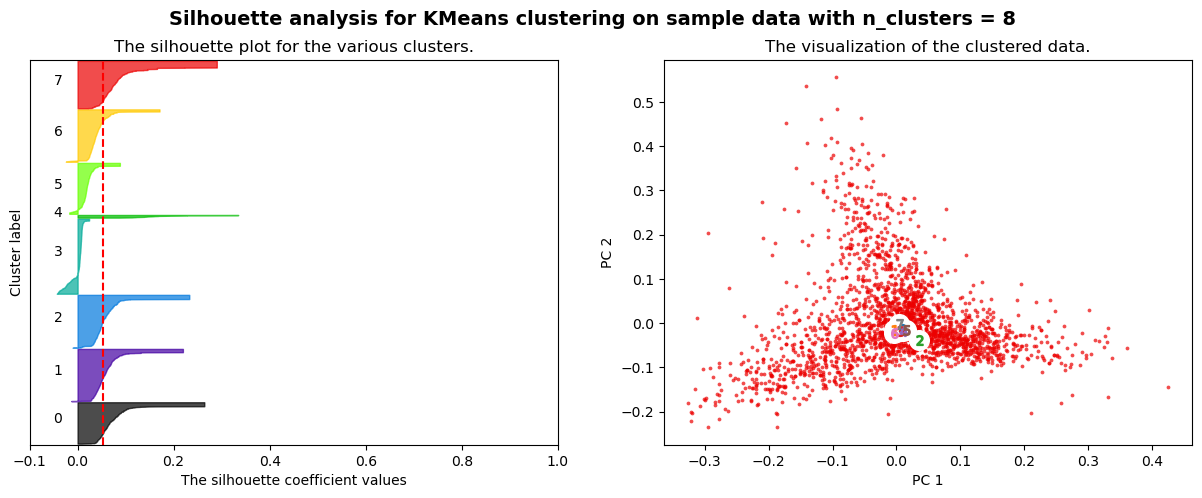

For n_clusters = 8, The average silhouette_score is : 0.052


In [70]:
plotSilhouette(8, abstract_TFVects.toarray())

/var/folders/4j/0fgh8w_10_z5wv518j7l299h0000gn/T/ipykernel_48326/1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


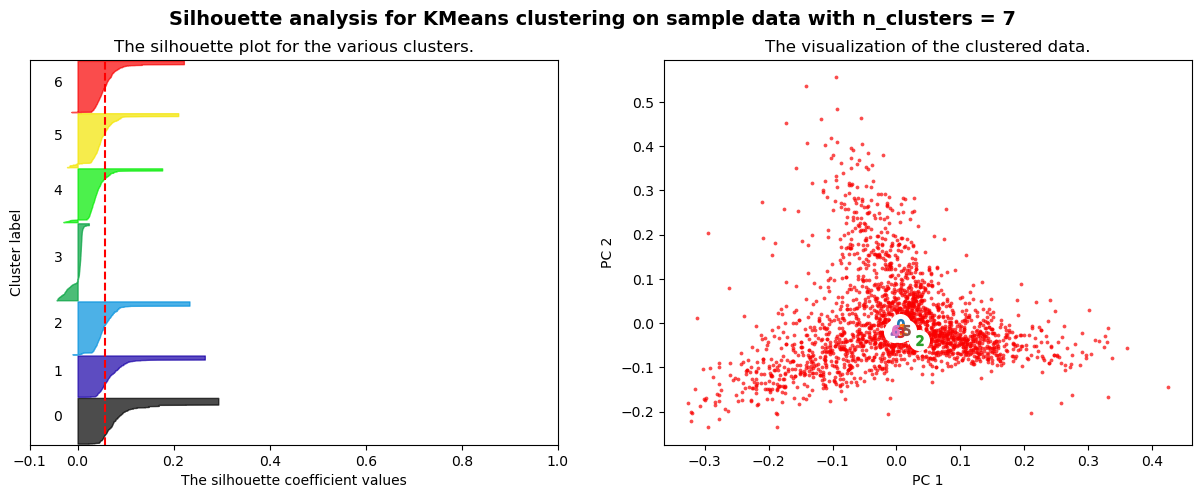

For n_clusters = 7, The average silhouette_score is : 0.056


In [71]:
plotSilhouette(7, abstract_TFVects.toarray())

In [72]:
plotSilhouette(6, abstract_TFVects.toarray())

/var/folders/4j/0fgh8w_10_z5wv518j7l299h0000gn/T/ipykernel_48326/1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


For n_clusters = 6, The average silhouette_score is : 0.056


In [73]:
plotSilhouette(5, abstract_TFVects.toarray())

/var/folders/4j/0fgh8w_10_z5wv518j7l299h0000gn/T/ipykernel_48326/1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


For n_clusters = 5, The average silhouette_score is : 0.048


/var/folders/4j/0fgh8w_10_z5wv518j7l299h0000gn/T/ipykernel_48326/1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


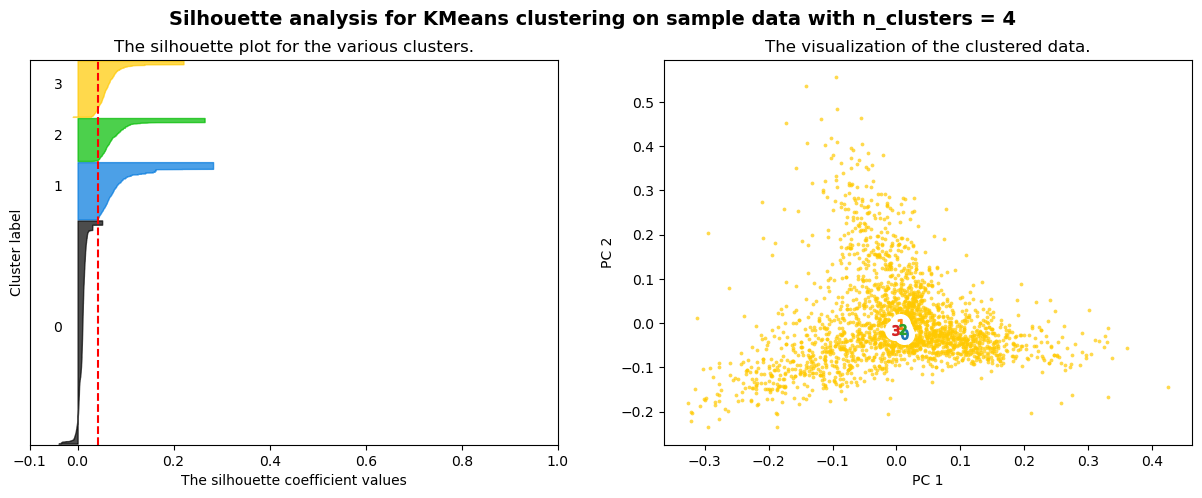

For n_clusters = 4, The average silhouette_score is : 0.041


In [74]:
plotSilhouette(4, abstract_TFVects.toarray())

/var/folders/4j/0fgh8w_10_z5wv518j7l299h0000gn/T/ipykernel_48326/1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


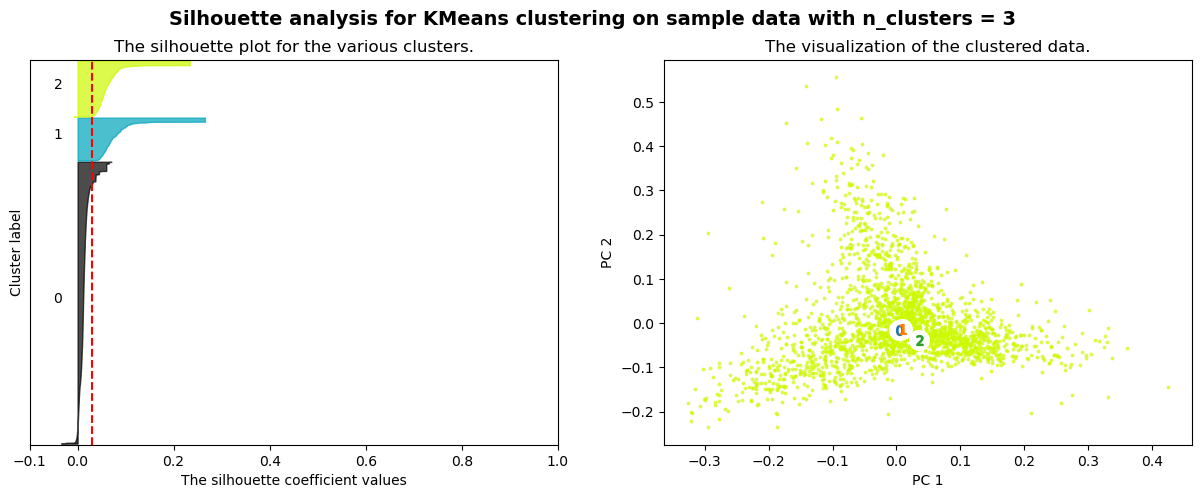

For n_clusters = 3, The average silhouette_score is : 0.031


In [75]:
plotSilhouette(3, abstract_TFVects.toarray())

/var/folders/4j/0fgh8w_10_z5wv518j7l299h0000gn/T/ipykernel_48326/1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


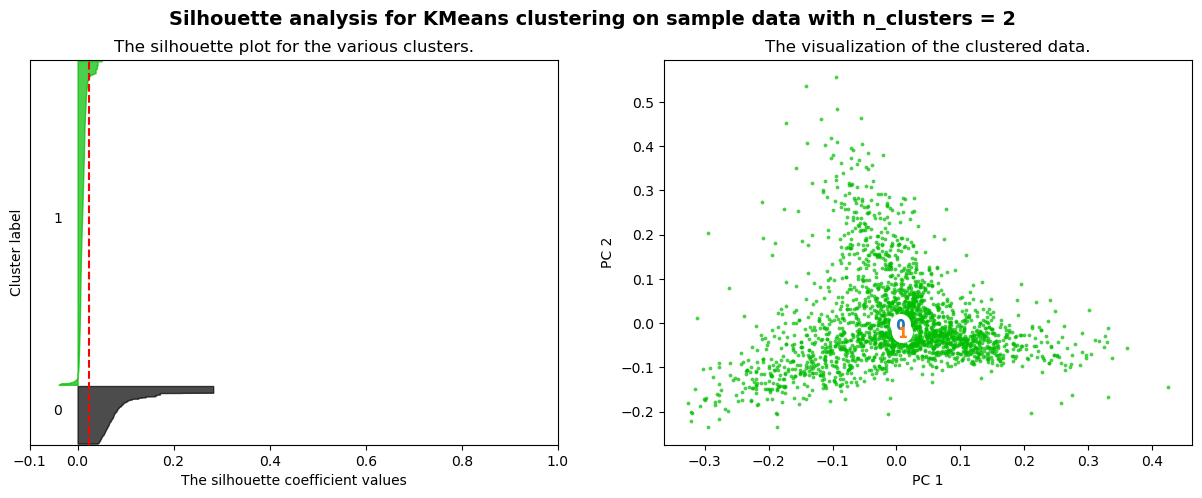

For n_clusters = 2, The average silhouette_score is : 0.024


In [76]:
plotSilhouette(2, abstract_TFVects.toarray())

From the analysis above, it is clear that 6 clusters are the best fit to the data because, first, it has the largest average silhouette_score and, second, it has the uniformly large sihouette_score as shown by the sihouette.

Plot clusters and features after reducing with PCA:

In [77]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(abstract_TFVects.toarray())
reduced_data = pca.transform(abstract_TFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [78]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) # Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids] # Turn the ids into words.
x = components[0, keyword_ids]
y = components[1, keyword_ids]

Then, let's build a color map for the true labels.

In [79]:
colordict = {
    'Sociology': 'red',
    'Psychology': 'orange',
    'Economics': 'green',
    'Chemistry': 'blue',
    'Biology': 'purple',
    'Medicine': 'cyan' 
}
colors = [colordict[f] for f in abstract_corpus['FieldOfStudy']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('Sociology', 'red'), ('Psychology', 'orange'), ('Economics', 'green'), ('Chemistry', 'blue'), ('Biology', 'purple'), ('Medicine', 'cyan')])


Let's plot the data using the true labels as the colors of our data points.

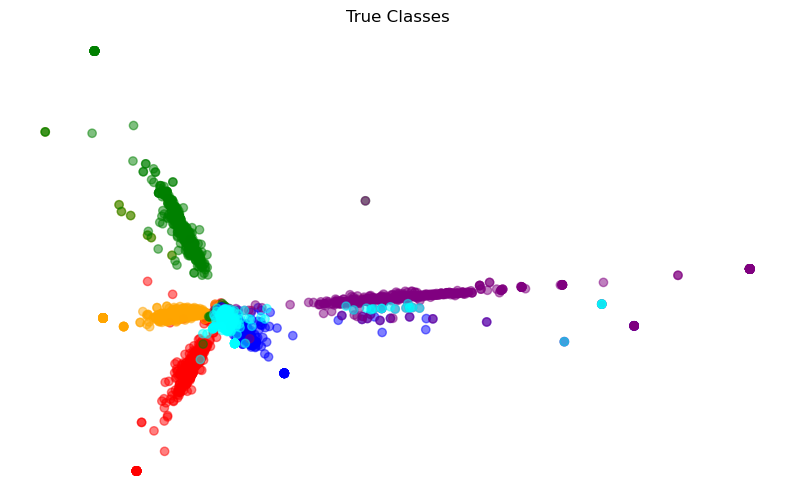

In [80]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Do a biplot and map the feature vectors to the same space:

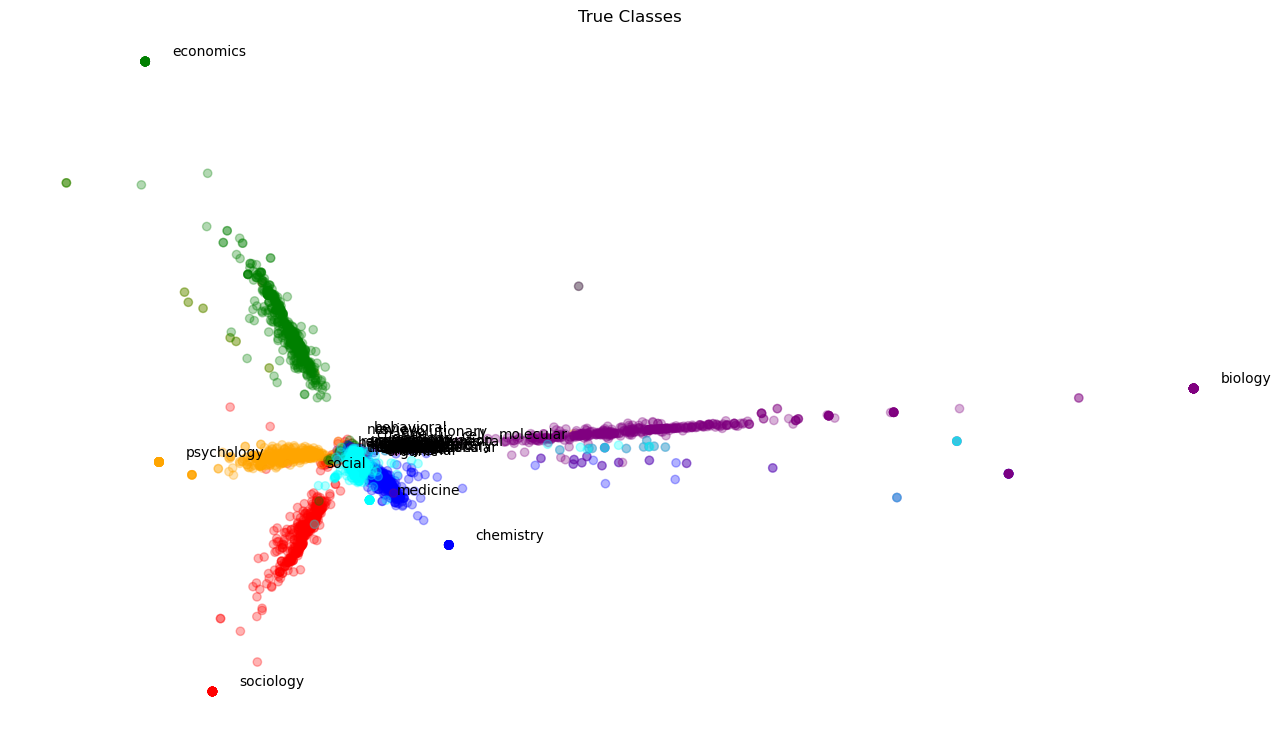

In [81]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [82]:
# Construct a dictionary to show the top 10 words for each cluster
terms = abstract_TFVectorizer.get_feature_names_out()
order_centroids = abstract_KM.cluster_centers_.argsort()[:, ::-1]

top_terms_per_cluster = {}

for i in range(6):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]  
    top_terms_per_cluster[list(colordict.keys())[i]] = top_terms  

df_top_terms = pandas.DataFrame(top_terms_per_cluster)

df_top_terms

Sociology     Psychology       Economics      Chemistry     Biology  \
0     economics       medicine       chemistry        biology   sociology   
1        theory       evidence         organic      molecular   knowledge   
2        social          based       medicinal           cell      social   
3           new    alternative    applications        systems    economic   
4      research    traditional         physics      chemistry      theory   
5      analysis  complementary           green       medicine     science   
6        review       clinical  supramolecular   evolutionary  historical   
7    behavioral       practice         surface   conservation         new   
8        change         health      analytical  developmental    emotions   
9  sociological   regenerative     atmospheric        ecology     culture   

       Medicine  
0    psychology  
1        social  
2      handbook  
3      positive  
4      research  
5      cultural  
6   personality  
7        health  
8  introduction  
9       methods

The feature words from the six clusters themselves are quite distinguishable (specific to each field of study) from the dataframe above. Also, the biplot does show relatively clear "dispersion" of feature words.

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [83]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [84]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [85]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate

/Users/samcong/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [86]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [87]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [88]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/samcong/anaconda3/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 43.        ,  45.        ,   0.        ,   2.        ],
       [ 48.        , 200.        ,   0.        ,   3.        ],
       [176.        , 201.        ,   0.        ,   4.        ],
       [ 55.        , 202.        ,   0.37033177,   5.        ],
       [ 19.        , 154.        ,   0.40914841,   2.        ],
       [ 60.        ,  94.        ,   0.44134524,   2.        ],
       [ 12.        ,  99.        ,   0.45096656,   2.        ],
       [  1.        , 204.        ,   0.4553535 ,   3.        ],
       [167.        , 206.        ,   0.4650683 ,   3.        ],
       [ 52.        ,  96.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

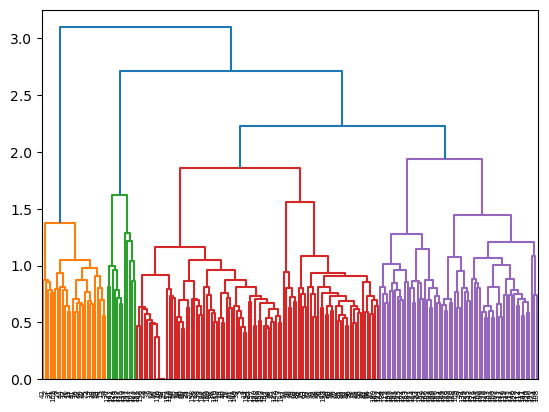

In [89]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

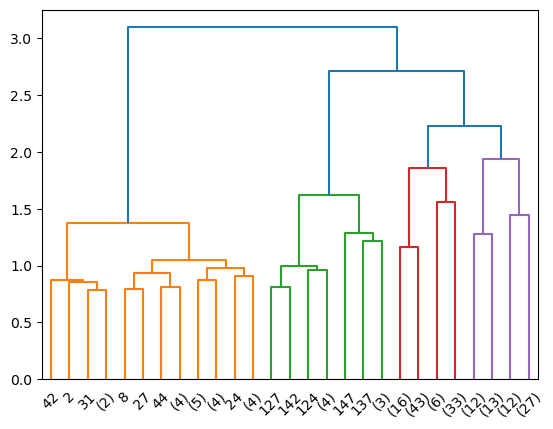

In [90]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [91]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3,
       1, 3, 3, 1, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4,
       3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 3, 4,
       2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 3, 4, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4,
       3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [92]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [93]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

text  \
0     \tIn certain Apple 13" RGB monitors there has ...   
1     Does anyone know how to reach Micron?  I am in...   
2     Hi there!\n\nCould some kind soul tell me what...   
3                                           "auto\nfrom   
4     \n\n    Don't believe the hype. There is no su...   
...                                                 ...   
2345  I was wondering if anyone out in net-land have...   
2346  \n\n\n\n\nI sold my '86 Sprint last April with...   
2347  Actually I wasn't too surprised, since I bough...   
2348  \n\nI couldnt agree more.  That is how it SHOU...   
2349  \nWarren Brown, the Washington Post's auto wri...   

                   category  \
0     comp.sys.mac.hardware   
1     comp.sys.mac.hardware   
2     comp.sys.mac.hardware   
3     comp.sys.mac.hardware   
4     comp.sys.mac.hardware   
...                     ...   
2345              rec.autos   
2346              rec.autos   
2347              rec.autos   
2348              rec.autos   
2349              rec.autos   

                                            source_file  kmeans_predictions  \
0     ../data/scikit_learn_data/20news_home/20news-b...                   2   
1     ../data/scikit_learn_data/20news_home/20news-b...                   2   
2     ../data/scikit_learn_data/20news_home/20news-b...                   2   
3     ../data/scikit_learn_data/20news_home/20news-b...                   2   
4     ../data/scikit_learn_data/20news_home/20news-b...                   2   
...                                                 ...                 ...   
2345  ../data/scikit_learn_data/20news_home/20news-b...                   2   
2346  ../data/scikit_learn_data/20news_home/20news-b...                   0   
2347  ../data/scikit_learn_data/20news_home/20news-b...                   0   
2348  ../data/scikit_learn_data/20news_home/20news-b...                   2   
2349  ../data/scikit_learn_data/20news_home/20news-b...                   2   

      wald_predictions  
0                    4  
1                    4  
2                    4  
3                    4  
4                    4  
...                ...  
2345                 4  
2346                 2  
2347                 2  
2348                 4  
2349                 4  

[2350 rows x 5 columns]

# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [94]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/Users/samcong/anaconda3/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

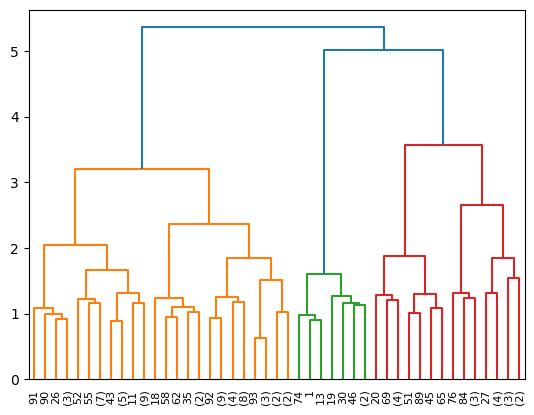

In [95]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [96]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)?

<font color="red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

First approach:

In [97]:
abstract_TFVects

<3563x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 12781 stored elements in Compressed Sparse Row format>

In [98]:
abstract_TFVects.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
abstract_CoocMat = abstract_TFVects * abstract_TFVects.T
abstract_CoocMat.setdiag(0)

/Users/samcong/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Only look at the first 50 texts of each class

In [100]:
selectIndices = []
indexToCat = []
for c in set(abstract_corpus['FieldOfStudy']):
    selectIndices += list(abstract_corpus[abstract_corpus['FieldOfStudy'] == c].index)[:50]
    indexToCat += [c] * 50

In [101]:
abstract_subCoocMat = abstract_CoocMat[selectIndices,:][:,selectIndices]

In [102]:
abstract_linkage_matrix = scipy.cluster.hierarchy.ward(abstract_subCoocMat.toarray())
abstract_linkage_matrix[:10]

array([[1.20000000e+02, 1.24000000e+02, 1.16927623e-01, 2.00000000e+00],
       [1.49000000e+02, 3.00000000e+02, 1.58267382e-01, 3.00000000e+00],
       [2.55000000e+02, 2.61000000e+02, 1.74443034e-01, 2.00000000e+00],
       [2.51000000e+02, 3.02000000e+02, 1.75914050e-01, 3.00000000e+00],
       [1.16000000e+02, 1.47000000e+02, 1.78127273e-01, 2.00000000e+00],
       [6.00000000e+01, 7.90000000e+01, 1.78647140e-01, 2.00000000e+00],
       [1.30000000e+02, 3.04000000e+02, 1.80344126e-01, 3.00000000e+00],
       [9.90000000e+01, 3.05000000e+02, 1.96327151e-01, 3.00000000e+00],
       [1.32000000e+02, 1.45000000e+02, 2.06013979e-01, 2.00000000e+00],
       [3.06000000e+02, 3.08000000e+02, 2.14750093e-01, 5.00000000e+00]])

Visualize the tree:

In [103]:
abstract_dendDat = scipy.cluster.hierarchy.dendrogram(abstract_linkage_matrix, get_leaves=True)

In [104]:
abstract_dendrogramDat = scipy.cluster.hierarchy.dendrogram(abstract_linkage_matrix , p=6, truncate_mode='level', get_leaves=True)

Examine the recursive content:

Here, I choose to go to the second level of hierarchy to compare the clusters of words at level two to that at level one:

In [132]:
from scipy.cluster.hierarchy import fcluster
from collections import Counter

top_level_clusters = fcluster(abstract_linkage_matrix, t=1, criterion='maxclust')
level_two_clusters = fcluster(abstract_linkage_matrix, t=2, criterion='maxclust')

# Create a subset DataFrame
subset_df = abstract_corpus.iloc[selectIndices].copy()
threshold_dist = 50
subset_df['Cluster'] = fcluster(abstract_linkage_matrix, threshold_dist, criterion='distance')

# Tokenize the titles once, outside the loop
subset_df['tokenized'] = subset_df[textColumn].apply(lambda x: lucem_illud.word_tokenize(x))
subset_df['normalized_tokens'] = subset_df['tokenized'].apply(lambda x: lucem_illud.normalizeTokens(x))

def get_top_words_for_cluster(cluster_labels, num_words=10):
    cluster_top_words = {}
    
    for cluster_num in set(cluster_labels):
        # Get tokenized titles in the current cluster
        tokenized_titles_in_cluster = subset_df[cluster_labels == cluster_num]['normalized_tokens']
        
        # Aggregate words in these titles
        all_words_in_cluster = [word for title in tokenized_titles_in_cluster for word in title]
        
        # Count word frequencies
        word_freq = Counter(all_words_in_cluster)

        # Get the most common words
        cluster_top_words[cluster_num] = word_freq.most_common(num_words)
    
    return cluster_top_words


top_level_top_words = get_top_words_for_cluster(top_level_clusters)
level_two_top_words = get_top_words_for_cluster(level_two_clusters)


# Print the top words for the top-level cluster
print("Top words for the top-level cluster:")
print(top_level_top_words)

# Print the top words for each level-two cluster
print("\nTop words for each level-two cluster:")
for cluster_num, top_words in level_two_top_words.items():
    print(f"Cluster {cluster_num}:")
    print(top_words)
    print("\n")

/Users/samcong/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Top words for the top-level cluster:
{1: [('medicine', 56), ('biology', 55), ('chemistry', 53), ('psychology', 52), ('sociology', 52), ('economics', 51), ('research', 12), ('social', 12), ('molecular', 12), ('american', 12)]}

Top words for each level-two cluster:
Cluster 1:
[('sociology', 51), ('social', 6), ('studies', 4), ('construction', 3), ('science', 3), ('technology', 3), ('economic', 3), ('century', 3), ('handbook', 2), ('theory', 2)]


Cluster 2:
[('biology', 55), ('medicine', 55), ('chemistry', 53), ('psychology', 52), ('economics', 51), ('molecular', 12), ('american', 11), ('research', 10), ('positive', 9), ('health', 8)]




The recursive content shows the distinction of diciplines (infered) from the title of selected papers. 

For Cluster 1, the top words are heavily skewed towards 'sociology' and related themes ('social', 'studies', 'construction', 'science', 'technology', 'economic'), indicating that it might represent documents related to social sciences and sociology.

For Cluster 2, the top words are more diverse, covering various disciplines ('biology', 'medicine', 'chemistry', 'psychology', 'economics'). The presence of 'molecular', 'american', 'research', 'positive', and 'health' suggests a mix of life sciences, social sciences, and health-related themes.

Second approach:

In [ ]:
abstract_hierarchicalClusters = scipy.cluster.hierarchy.fcluster(abstract_linkage_matrix , 6, 'maxclust')
abstract_hierarchicalClusters

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6,
       6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6], d

In [ ]:
abstract_linkage_matrix_full = scipy.cluster.hierarchy.ward(abstract_CoocMat.toarray())
abstract_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(abstract_linkage_matrix_full, 6, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(abstract_corpus['FieldOfStudy'], abstract_hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(abstract_corpus['FieldOfStudy'], abstract_hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(abstract_corpus['FieldOfStudy'], abstract_hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(abstract_corpus['FieldOfStudy'], abstract_hierarchicalClusters_full)))

/Users/samcong/anaconda3/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For our complete clusters:
Homogeneity: 0.701
Completeness: 0.725
V-measure: 0.713
Adjusted Rand Score: 0.618


The performance here is almost identical compared to kmeans in Exercise 1 (the numbers are only slightly lower).

I believe there could be some reasons behind. First, my corpus has an inherently nested cluster structure (e.g., subdisciplines of a field of study). Second, I think the number of clusters chose (in both cases, 6) is an appropriate number for both k-means and hierarchical clustering. Third, since K-means assumes that clusters are spherical and tend to be of similar sizes, the similar performance indicate that my data conforms to these assumptions.



In [ ]:
abstract_corpus['wald_predictions'] = abstract_hierarchicalClusters_full
abstract_corpus

FieldOfStudy                                              Title  \
0       Sociology  Handbook of Theory and Research for the Sociol...   
1       Sociology  Social Capital: Its Origins and Applications i...   
2       Sociology  Some Elements of a Sociology of Translation: D...   
3       Sociology                             Sociology of Childhood   
4       Sociology    Outsiders Studies in the Sociology of Deviance.   
...           ...                                                ...   
3554     Medicine  Moving towards evidence based emergency medici...   
3555     Medicine  Women in academic medicine. Combining career a...   
3556     Medicine                 Career choice in academic medicine   
3557     Medicine  Guidelines for preventing and treating vitamin...   
3558     Medicine               Veterinary Medicine and Human Health   

                                                 Author  \
0                                         J. Richardson   
1                                             A. Portes   
2                                             M. Callon   
3                                         S. Grieshaber   
4                                             B. Werble   
...                                                 ...   
3554  S. Carley, K. Mackway-Jones, Alice Y. M. Jones...   
3555      Wendy Levinson, S. W. Tolle, Charles E. Lewis   
3556  S. Straus, Christine Straus, K. Tzanetos, the ...   
3557  M. Holick, N. Binkley, H. Bischoff-Ferrari, C....   
3558                                       W. H. Wright   

                                               Abstract  kmeans_predictions  \
0     The first of its kind, this handbook synthesiz...                   0   
1     This paper reviews the origins and definitions...                   0   
2     This paper outlines a new approach to the stud...                   0   
3     The sociology of childhood has been used incre...                   0   
4     This 1966 paperback edition of a publication w...                   0   
...                                                 ...                 ...   
3554  Keeping up to date with new research and clini...                   3   
3555  We conducted a national survey to explore how ...                   3   
3556  OBJECTIVES: To review systematically the evide...                   3   
3557  Boston University School of Medicine (M.F.H.),...                   4   
3558  According to the preface, this work is designe...                   3   

      wald_predictions  
0                    4  
1                    4  
2                    4  
3                    4  
4                    4  
...                ...  
3554                 6  
3555                 6  
3556                 6  
3557                 6  
3558                 6  

[3559 rows x 6 columns]

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

Here again we make use of `lucem_illud` functions. The source code of both of these is in [processing.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/processing.py).

In [133]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/Users/samcong/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [134]:
senReleasesTraining[::100]

Unnamed: 0                         name  \
0              0      10Apr2008Voinovich3.txt   
100          100    19Jan2005Voinovich289.txt   
200          200     27Sep2007Voinovich65.txt   
300          300      9Jan2008Voinovich32.txt   
400          400        14Dec2007Obama184.txt   
500          500        17Oct2007Obama247.txt   
600          600        21Dec2007Obama170.txt   
700          700        24Oct2007Obama237.txt   
800          800        28Sep2005Obama647.txt   
900          900          4Jun2008Obama65.txt   
1000        1000         8Sep2006Obama503.txt   
1100        1100    25Jul2007Whitehouse83.txt   
1200        1200        10Feb2005Snowe174.txt   
1300        1300         12Apr2005Snowe56.txt   
1400        1400        13Nov2007Snowe212.txt   
1500        1500        14Jun2007Snowe357.txt   
1600        1600        15Sep2004Snowe423.txt   
1700        1700        17Apr2006Snowe391.txt   
1800        1800        18Dec2007Snowe196.txt   
1900        1900        19May2006Snowe308.txt   
2000        2000        20Feb2008Snowe125.txt   
2100        2100        21Oct2005Snowe242.txt   
2200        2200  11May2006Rockefeller196.txt   
2300        2300  19Dec2005Rockefeller248.txt   
2400        2400  26May2006Rockefeller182.txt   
2500        2500   6Dec2004Rockefeller327.txt   
2600        2600    14Apr2005Murkowski248.txt   
2700        2700     1Sep2004Murkowski348.txt   
2800        2800    27Sep2004Murkowski327.txt   
2900        2900      6Nov2007Murkowski18.txt   
3000        3000        05Oct2007McCain82.txt   
3100        3100        15Sep2006McCain81.txt   
3200        3200        26Mar2007McCain33.txt   
3300        3300            14Apr2008Kyl3.txt   
3400        3400          18May2006Kyl214.txt   
3500        3500          23Mar2007Kyl113.txt   
3600        3600          29Sep2006Kyl154.txt   
3700        3700           7Jun2005Kyl376.txt   
3800        3800        19May2006Baucus19.txt   
3900        3900         10Nov2006Frist25.txt   
4000        4000        15Dec2004Frist200.txt   
4100        4100        17Nov2004Frist246.txt   
4200        4200        20Dec2004Frist197.txt   
4300        4300        23Jun2006Frist174.txt   
4400        4400        27Oct2005Frist460.txt   
4500        4500         2Aug2004Frist352.txt   
4600        4600         3Nov2004Frist269.txt   
4700        4700         7Sep2004Frist339.txt   
4800        4800         9Sep2004Frist332.txt   

                                                   text  \
0     SEN. VOINOVICH SECURES ASSISTANCE FOR STRUGGLI...   
100   SEN. VOINOVICH NAMES NEW CHIEF OF STAFF\n  Sen...   
200   $1.5 MILLION AVAILABLE FOR CONTROL OF DEVASTAT...   
300   SEN. VOINOVICH LETTER ON LIHEAP, ENERGY/ENVIRO...   
400      Obama Statement on the Farm Bill   U S  Sen...   
500      Durbin  Obama Emanuel Call for Public heari...   
600      Landrieu  McCaskill  Obama Applaud Long Ove...   
700      Obama  Bond Demand Pentagon Report on PTSD ...   
800      Obama  Dodd and Rep  Lewis Hold Press Confe...   
900      Durbin  Obama  Emanuel  Congratulate Chicag...   
1000     Obama  Durbin Ask Department of Labor to He...   
1100  SENS. REED, WHITEHOUSE SEEK TO PROTECT WETLAND...   
1200  SEN. SNOWE DISCUSSES UNMATCHED CAPABILITIES OF...   
1300  SEN. SNOWE PLEASED WITH PINE SHOOT BEETLE DECI...   
1400  SEN. SNOWE PAYS TRIBUTE TO AMERICA'S HEROES\n ...   
1500  SEN. SNOWE ANNOUNCES $197 MILLION CONTRACT TO ...   
1600  SEN. SNOWE APPLAUDS SENATE APPROVAL OF MEASURE...   
1700  SEN. SNOWE CALLS FOR INCREASED CHILDCARE FUNDI...   
1800  SEN. SNOWE BLASTS FCC DECISION TO LOOSEN MEDIA...   
1900  SEN. SNOWE ISSUES STATEMENT AT SENATE CONFIRMA...   
2000  SEN. SNOWE: OMISSION OF UNEMPLOYMENT INSURANCE...   
2100  SEN. SNOWE VOTES FOR EMERGENCY LOW INCOME HEAT...   
2200  SEN. ROCKEFELLER ISSUES STATEMENT ON NSA SURVE...   
2300  SEN. ROCKEFELLER FIGHTS TO SIMPLIFY EARNED INC...   
2400  SEN. ROCKEFELLER COMMENTS ON SENATE CONFIRMATI...   
2500  SEN. ROCKEFELLE

In [135]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

In [136]:
senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [137]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [138]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [139]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [140]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [141]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 10Apr2008Voinovich3.txt
are: [(5, 0.99164677)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [142]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [143]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

name  \
1         10Apr2008Voinovich4.txt   
101     19Jan2007Voinovich137.txt   
201      27Sep2007Voinovich66.txt   
301      9Mar2005Voinovich277.txt   
401         14Feb2008Obama147.txt   
501         17Oct2007Obama248.txt   
601         21Feb2006Obama584.txt   
701         24Sep2007Obama274.txt   
801         28Sep2007Obama264.txt   
901           4Jun2008Obama66.txt   
1001         9Apr2007Obama431.txt   
1101   25May2007Whitehouse103.txt   
1201        10Feb2005Snowe175.txt   
1301        12Apr2007Snowe414.txt   
1401        13Nov2007Snowe213.txt   
1501        14Mar2005Snowe102.txt   
1601        15Sep2004Snowe424.txt   
1701        17Apr2006Snowe392.txt   
1801        18Dec2007Snowe197.txt   
1901        19May2006Snowe309.txt   
2001        20Jan2006Snowe110.txt   
2101        21Oct2005Snowe243.txt   
2201  11Oct2004Rockefeller336.txt   
2301   19Feb2008Rockefeller20.txt   
2401  26May2006Rockefeller183.txt   
2501   6Dec2006Rockefeller137.txt   
2601    14Dec2006Murkowski104.txt   
2701     1Sep2005Murkowski204.txt   
2801    27Sep2004Murkowski328.txt   
2901     6Oct2004Murkowski311.txt   
3001        05Sep2006McCain76.txt   
3101        16Apr2007McCain39.txt   
3201        26Mar2007McCain34.txt   
3301          14Aug2006Kyl169.txt   
3401          18Nov2005Kyl295.txt   
3501          23Sep2004Kyl451.txt   
3601          29Sep2006Kyl155.txt   
3701           7Mar2005Kyl406.txt   
3801         1Feb2007Baucus55.txt   
3901        10Oct2004Frist289.txt   
4001        15Dec2004Frist201.txt   
4101        17Nov2004Frist247.txt   
4201        20Feb2005Frist151.txt   
4301        23Mar2006Frist290.txt   
4401        27Oct2005Frist461.txt   
4501         2Aug2006Frist110.txt   
4601         3Nov2004Frist270.txt   
4701         7Sep2005Frist496.txt   
4801         9Sep2004Frist333.txt   

                                                 topics   topic_0   topic_1  \
1                      [(4, 0.871469), (6, 0.11817302)]  0.000000  0.000000   
101                   [(0, 0.34677878), (7, 0.6367333)]  0.346779  0.000000   
201   [(0, 0.39157084), (5, 0.12335437), (8, 0.47411...  0.391571  0.000000   
301   [(3, 0.4338811), (4, 0.11355665), (6, 0.449068...  0.000000  0.000000   
401                                   [(6, 0.98288965)]  0.000000  0.000000   
501                                   [(7, 0.98962426)]  0.000000  0.000000   
601   [(5, 0.16583194), (6, 0.5998468), (7, 0.059641...  0.000000  0.000000   
701                                    [(3, 0.9893561)]  0.000000  0.000000   
801                    [(0, 0.7312851), (2, 0.2365104)]  0.731285  0.000000   
901                   [(4, 0.4153251), (8, 0.52598757)]  0.000000  0.000000   
1001  [(4, 0.36488953), (6, 0.5862738), (8, 0.040658...  0.000000  0.000000   
1101                 [(2, 0.66490185), (3, 0.32569453)]  0.000000  0.000000   
1201                [(7, 0.91494024), (9, 0.076091506)]  0.000000  0.000000   
1301                                       [(8, 0.986)]  0.000000  0.000000   
1401                 [(1, 0.92624295), (2, 0.06777347)]  0.000000  0.926243   
1501                                  [(9, 0.98790884)]  0.000000  0.000000   
1601  [(2, 0.19211791), (5, 0.16750807), (8, 0.62353...  0.000000  0.000000   
1701                  [(6, 0.19563223), (8, 0.7561816)]  0.000000  0.000000   
1801  [(0, 0.32431307), (6, 0.041568857), (7, 0.5041...  0.324313  0.000000   
1901  [(0, 0.10259885), (4, 0.4870436), (8, 0.216118...  0.102599  0.000000   
2001  [(1, 0.025479697), (2, 0.307045), (3, 0.132452...  0.000000  0.025480   
2101  [(0, 0.07050293), (1, 0.72522455), (4, 0.07434...  0.070503  0.725225   
2201  [(0, 0.1716144), (3, 0.031623457), (5, 0.29789...  0.171614  0.000000   
2301  [(2, 0.051837813), (6, 0.5075833), (8, 0.34634...  0.000000  0.000000   
2401  [(3, 0.34797773), (4, 0.15514652), (6, 0.39949...  0.000000  0.000000   
2501  [(0, 0.16131592), (3, 0.34062773), (5, 0.24849...  0.161316  0.000000   
2601  [(1, 0.40498853), (3, 0.32956478), (6, 

Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [144]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV

topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
0      0.0  0.000000  0.000000  0.000000  0.000000  0.991647  0.000000   
1      0.0  0.000000  0.000000  0.000000  0.871469  0.000000  0.118173   
2      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.0  0.126319  0.000000  0.227373  0.197687  0.000000  0.000000   
4      0.0  0.000000  0.287068  0.231098  0.000000  0.000000  0.000000   
5      0.0  0.000000  0.000000  0.236063  0.000000  0.000000  0.000000   
6      0.0  0.000000  0.000000  0.960178  0.000000  0.000000  0.000000   
7      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8      0.0  0.000000  0.000000  0.971327  0.000000  0.000000  0.000000   
9      0.0  0.967752  0.000000  0.000000  0.000000  0.000000  0.000000   

    topic_7   topic_8   topic_9  
0  0.000000  0.000000  0.000000  
1  0.000000  0.000000  0.000000  
2  0.822068  0.135322  0.000000  
3  0.177586  0.000000  0.259331  
4  0.461821  0.000000  0.000000  
5  0.739708  0.000000  0.000000  
6  0.000000  0.000000  0.000000  
7  0.272154  0.000000  0.709283  
8  0.000000  0.000000  0.000000  
9  0.000000  0.000000  0.000000

First we can visualize as a stacked bar chart:

In [145]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)


plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

In [146]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [147]:
senlda.show_topic(1)

[('transit', 0.0065548047),
 ('port', 0.0062153167),
 ('patriot', 0.0051920745),
 ('ports', 0.0045286734),
 ('aliens', 0.0038648),
 ('ocean', 0.0037184143),
 ('entry', 0.003543301),
 ('rail', 0.0033168246),
 ('constitution', 0.0028716996),
 ('sba', 0.0027644853)]

And if we want to make a dataFrame:

In [148]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

Topic_0       Topic_1   Topic_2        Topic_3    Topic_4  \
0             meth       transit      cell          korea      alito   
1  methamphetamine          port   tsunami       minister     darfur   
2             lock       patriot      stem         africa     israel   
3            ridge         ports       flu          sudan  anchorage   
4           reagan        aliens     avian    palestinian  predators   
5          counter         ocean  pandemic       nominees        sex   
6              oak         entry  diseases        jenkins      sudan   
7            india          rail    miners         museum       veto   
8           mexico  constitution    sickle  proliferation      smart   
9          ethanol           sba     eagle       genocide    lebanon   

     Topic_5       Topic_6        Topic_7    Topic_8    Topic_9  
0    circuit  firefighters           aids    memphis    obesity  
1     judges          afgp            hiv   nominees   earmarks  
2  nashville    sanitation      nashville      parks   asbestos  
3        boy         cable           card  anchorage       nato  
4    tobacco          fema        pension       king   lobbying  
5   marriage         burma       discount   teachers       coal  
6       chip         stock  deductibility        fcc     cancer  
7     bolton           tri         autism    hastert  childhood  
8     recess           sri      fairbanks        mrs    nursing  
9     scouts           epa        genetic     martin        hud

We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 640x480 with 0 Axes>

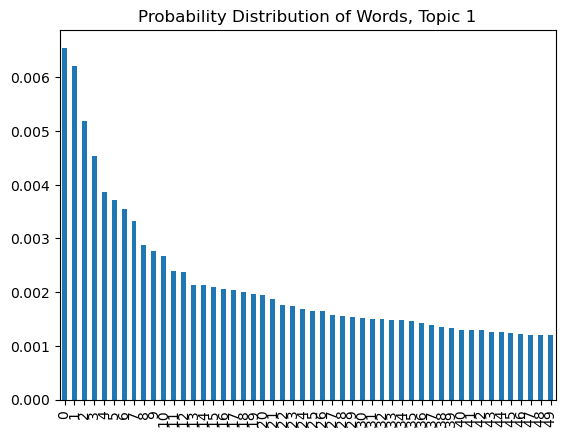

In [149]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [150]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

/Users/samcong/anaconda3/lib/python3.11/site-packages/gensim/models/ldamodel.py:850: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


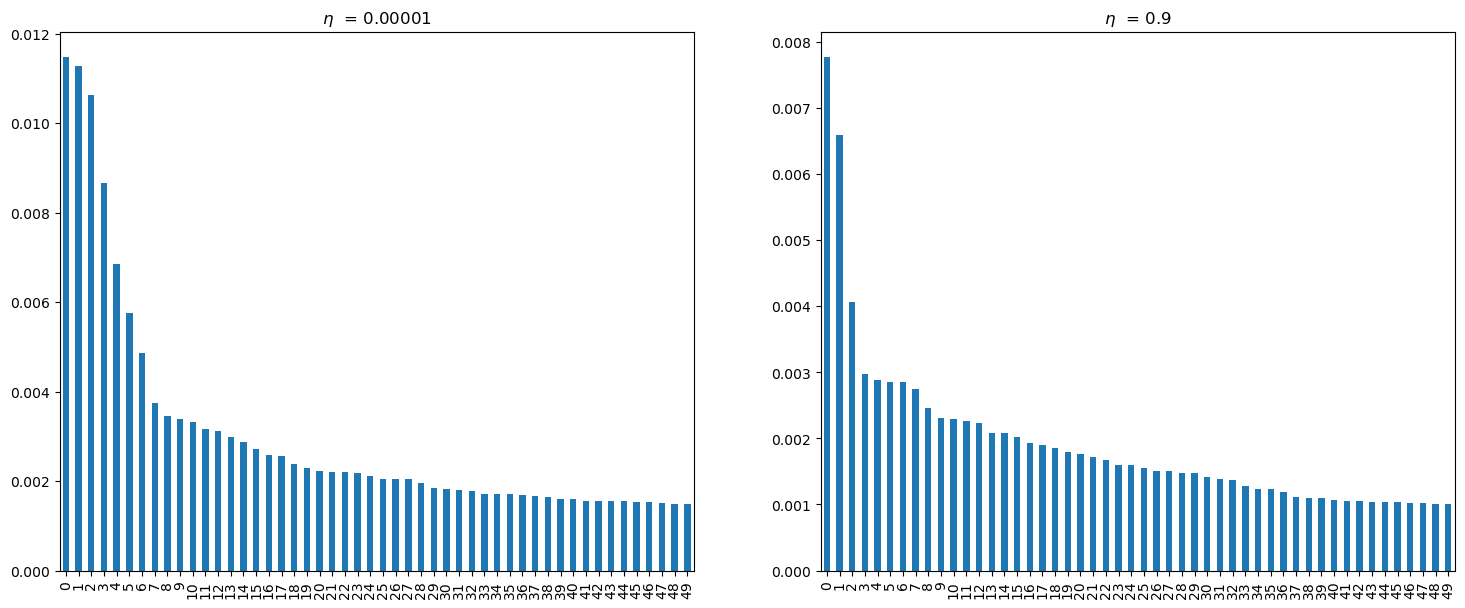

In [151]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

### Heirarchial Dirichlet Process

We use LDA topic modeling above, but a similar alternative model you may run across is Hierarchical Dirichlet Processes, a nonparametric generalization of LDA. See, for example, [Teodoridis et al 2020](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3596233). One difference is how the researcher selects the number of topics.

In [152]:
from gensim.models import HdpModel

In [153]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [154]:
hdpmodel.print_topics()

[(0,
  '0.001*fishing + 0.001*chip + 0.001*anchorage + 0.001*korea + 0.001*memphis + 0.001*meth + 0.001*nominees + 0.001*circuit + 0.001*cell + 0.001*methamphetamine'),
 (1,
  '0.004*cable + 0.003*fcc + 0.003*channels + 0.002*contractors + 0.002*coal + 0.002*media + 0.002*ownership + 0.002*trail + 0.002*importation + 0.002*earmarks'),
 (2,
  '0.003*audience + 0.003*stem + 0.003*wounded + 0.003*nicholson + 0.002*disability + 0.002*mccaskill + 0.002*burma + 0.002*cells + 0.002*chip + 0.002*cancer'),
 (3,
  '0.007*mercury + 0.002*sba + 0.002*epa + 0.002*heating + 0.002*pollution + 0.001*earth + 0.001*veteran + 0.001*liheap + 0.001*winter + 0.001*plants'),
 (4,
  '0.002*epa + 0.002*vfw + 0.002*amt + 0.001*borrowers + 0.001*wyden + 0.001*subprime + 0.001*kids + 0.001*anchorage + 0.001*sba + 0.001*fisa'),
 (5,
  '0.003*tibet + 0.002*lama + 0.002*dalai + 0.002*brac + 0.001*lumber + 0.001*steel + 0.001*tibetan + 0.001*lake + 0.001*epa + 0.001*truck'),
 (6,
  '0.004*ethanol + 0.004*lugar + 0.00

Gensim sets the default number of topics as 150. This [stack overflow link](https://stackoverflow.com/questions/31543542/hierarchical-dirichlet-process-gensim-topic-number-independent-of-corpus-size) walks you through how to truncate these topics.

In [155]:
hdptexts = hdpmodel[corpus]

In [156]:
hdptexts[0]

[(21, 0.5410686366026587), (32, 0.4477106108262319)]

This [HDP tutorial](https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a) walks us through alternative HDP implementations outside of gensim.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<font color="red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</font>

For this exercise, I will focus on the abstract of psychology papers (so that each abstract becomes one document).

In [157]:
psychology_corpus = scrape_abstract("Psychology")

In [158]:
psychology_corpus["Abstract"][:20]

0     1. Introduction to Engineering Psychology and ...
1     BOOK REVIEW: Csikszentmihalyi, M. (2008). Flow...
2     1. Psychology, Science and Research. 2. Measur...
3     One possible reason for the continued neglect ...
4     Research Design in Clinical Psychology helps s...
5     In this article, the author describes a new th...
6     The psychology of interpersonal relations , Th...
7     A science of positive subjective experience, p...
8     A GOOD and clear translation of Freud's short ...
9     The psychological principles that govern the p...
10    Foreword Introduction by Michael M. Sokal Psyc...
11    In the context of the development of prototypi...
12    This seventh edition of Statistical Methods fo...
13    Positive psychology has flourished in the last...
14    Contents: Preface. An Applied Information-Proc...
15    Environmental psychology, though a fast-growin...
16    Foreword by Sheldon H. White Introduction Endu...
17    The work cited by the Nobel committee was 

In [159]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer_psychology = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer_psychology.fit_transform(psychology_corpus["Abstract"])

In [160]:
psychology_corpus['tokenized_text'] = psychology_corpus["Abstract"].apply(lambda x: lucem_illud.word_tokenize(x))
psychology_corpus['normalized_tokens'] = psychology_corpus['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))
psychology_corpus['reduced_tokens'] = psychology_corpus['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer_psychology.vocabulary_.keys()))

/Users/samcong/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [161]:
psychology_dictionary = gensim.corpora.Dictionary(psychology_corpus['reduced_tokens'])

# Serialize the corpus as a file and load it
gensim.corpora.MmCorpus.serialize('abstract.mm', [psychology_dictionary.doc2bow(text) for text in psychology_corpus['reduced_tokens']])
psychology_senmm = gensim.corpora.MmCorpus('abstract.mm')

psychology_senlda = gensim.models.ldamodel.LdaModel(corpus=psychology_senmm, 
                                                    id2word=psychology_dictionary, 
                                                    num_topics=8, 
                                                    alpha="auto", 
                                                    eta = "auto")

Creates a `dataFrame` that records which topics our model predicts the paper abstract load on

In [162]:
psychology_ldaDF = pandas.DataFrame({
    'topics' : [psychology_senlda[psychology_dictionary.doc2bow(l)] for l in psychology_corpus['reduced_tokens']]
    })

Transform the dataframe so that each topic has its own column:

In [163]:
#Dict to temporally hold the probabilities
psychology_topicsProbDict = {i : [0] * len(psychology_ldaDF) for i in range(psychology_senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(psychology_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        psychology_topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(psychology_senlda.num_topics):
    psychology_ldaDF['topic_{}'.format(topicNum)] = psychology_topicsProbDict[topicNum]

psychology_ldaDF[1::20]

topics   topic_0   topic_1  \
1    [(0, 0.010596996), (1, 0.010313547), (2, 0.011...  0.010597  0.010314   
21                   [(1, 0.8793401), (2, 0.11134523)]  0.000000  0.879340   
41                                    [(0, 0.9813269)]  0.981327  0.000000   
61                                   [(7, 0.98652816)]  0.000000  0.000000   
81                  [(0, 0.14387095), (2, 0.84580046)]  0.143871  0.000000   
101                                   [(5, 0.9759595)]  0.000000  0.000000   
121                                   [(2, 0.9858274)]  0.000000  0.000000   
141  [(1, 0.1776625), (2, 0.44402826), (4, 0.359139...  0.000000  0.177663   
161                  [(1, 0.7656247), (4, 0.22607347)]  0.000000  0.765625   
181                                  [(4, 0.97966796)]  0.000000  0.000000   
201                                   [(1, 0.9691896)]  0.000000  0.969190   
221                  [(3, 0.48201975), (6, 0.5073435)]  0.000000  0.000000   
241                                   [(2, 0.9957292)]  0.000000  0.000000   
261                  [(0, 0.7315956), (4, 0.25931618)]  0.731596  0.000000   
281                  [(1, 0.7828112), (7, 0.21002455)]  0.000000  0.782811   
301  [(0, 0.46104926), (1, 0.21254534), (7, 0.31754...  0.461049  0.212545   
321                                   [(3, 0.9984081)]  0.000000  0.000000   
341                                  [(7, 0.99384177)]  0.000000  0.000000   
361                  [(0, 0.47470745), (2, 0.5105364)]  0.474707  0.000000   
381  [(4, 0.06974405), (5, 0.29411057), (7, 0.63066...  0.000000  0.000000   
401  [(0, 0.4331757), (1, 0.10641299), (6, 0.4572709)]  0.433176  0.106413   
421                                   [(0, 0.9722869)]  0.972287  0.000000   
441  [(0, 0.106488824), (4, 0.7922176), (6, 0.09823...  0.106489  0.000000   
461                                  [(5, 0.98581994)]  0.000000  0.000000   
481                   [(0, 0.06076703), (1, 0.923241)]  0.060767  0.923241   
501                                   [(4, 0.9938567)]  0.000000  0.000000   
521                                   [(4, 0.9724483)]  0.000000  0.000000   
541                                   [(3, 0.9751268)]  0.000000  0.000000   
561                                    [(4, 0.990508)]  0.000000  0.000000   
581                                   [(0, 0.9656116)]  0.965612  0.000000   

      topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  
1    0.011375  0.000000  0.011035  0.010109  0.926494  0.010380  
21   0.111345  0.000000  0.000000  0.000000  0.000000  0.000000  
41   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
61   0.000000  0.000000  0.000000  0.000000  0.000000  0.986528  
81   0.845800  0.000000  0.000000  0.000000  0.000000  0.000000  
101  0.000000  0.000000  0.000000  0.975959  0.000000  0.000000  
121  0.985827  0.000000  0.000000  0.000000  0.000000  0.000000  
141  0.444028  0.000000  0.359140  0.000000  0.000000  0.000000  
161  0.000000  0.000000  0.226073  0.000000  0.000000  0.000000  
181  0.000000  0.000000  0.979668  0.000000  0.000000  0.000000  
201  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
221  0.000000  0.482020  0.000000  0.000000  0.507343  0.000000  
241  0.995729  0.000000  0.000000  0.000000  0.000000  0.000000  
261  0.000000  0.000000  0.259316  0.000000  0.000000  0.000000  
281  0.000000  0.000000  0.000000  0.000000  0.000000  0.210025  
301  0.000000  0.000000  0.000000  0.000000  0.000000  0.317543  
321  0.000000  0.998408  0.000000  0.000000  0.000000  0.000000  
341  0.000000  0.000000  0.000000  0.000000  0.000000  0.993842  
361  0.510536  0.000000  0.000000  0.000000  0.000000  0.000000  
381  0.000000  0.000000  0.069744  0.294111  0.000000  0.630663  
401  0.000000  0.000000  0.000000  0.000000  0.457271  0.000000  
421  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
441  0.000000  0.000000  0.792218  0.000000  0.098233  0.000000  
461  0.000000  0.000000  0.000000  0.985820  

In [164]:
abstract_topicsDict = {}
for topicNum in range(psychology_senlda.num_topics):
    topicWords = [w for w, p in psychology_senlda.show_topic(topicNum)]
    abstract_topicsDict['Topic_{}'.format(topicNum)] = topicWords

abstrct_wordRanksDF = pandas.DataFrame(abstract_topicsDict)
abstrct_wordRanksDF

Topic_0      Topic_1        Topic_2     Topic_3      Topic_4  \
0       health       health    personality  university     positive   
1      chapter       school       behavior  department       people   
2      methods        sport       learning    learning          new   
3         work  performance           self    positive         work   
4  qualitative       stress        chapter        kong     behavior   
5     identity  personality  environmental        book  qualitative   
6   individual         book   evolutionary        hong    processes   
7    education     practice           work     chinese     learning   
8    processes         self     individual        life      article   
9     behavior         work       cultural       model         data   

       Topic_5      Topic_6        Topic_7  
0     cultural      chapter       cultural  
1     learning     religion           work  
2       review  personality        chapter  
3         book      history       behavior  
4         life          new        culture  
5       people         work       positive  
6  personality         self     individual  
7        based     theories  understanding  
8          new     learning         health  
9        study      studies           life

Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

Visualize Document-Topic Loadings:

In [165]:
# Define a functino to visualize document-topic loadings
def visualize_document_topic_loadings(lda_model, lda_df, N=10):
    K = lda_model.num_topics  # Number of topics
    ind = np.arange(N)  # the x-axis locations for the documents
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)
    
    for k in range(K):
        topic_proportions = lda_df[f'topic_{k}'].values[:N]  # Convert to NumPy array if it's a DataFrame
        color = plt.cm.coolwarm(k / K)  # Color for this topic
        if k == 0:
            p = plt.bar(ind, topic_proportions, width, color=color)
        else:
            p = plt.bar(ind, topic_proportions, width, bottom=height_cumulative, color=color)
        height_cumulative += topic_proportions
        plots.append(p)
    
    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topic Proportions')
    plt.title('Topic Proportions in Documents')
    plt.xticks(ind + width/2, [f'Doc {i}' for i in range(N)], rotation='vertical')
    plt.yticks(np.arange(0, 1.1, 0.1))
    topic_labels = [f'Topic {k}' for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', bbox_to_anchor=(1, .5))
    plt.tight_layout()
    plt.show()

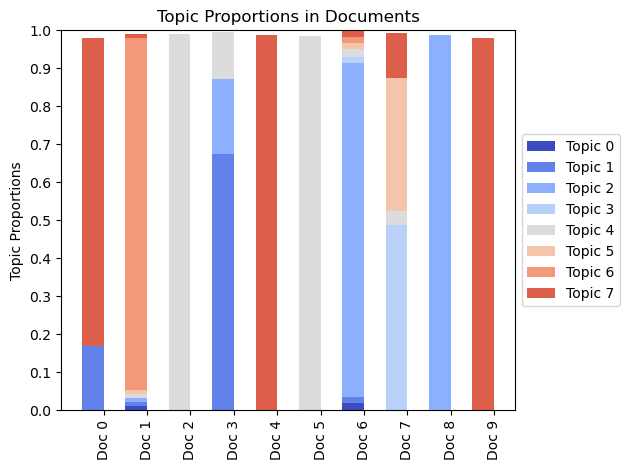

In [166]:
visualize_document_topic_loadings(psychology_senlda, psychology_ldaDF, N=10)

Visualize Topic-Word Loadings:

In [167]:
# Define a function to visualize Topic-Word Loadings:
def visualize_topic_word_loadings(lda_model, num_words=10):
    K = lda_model.num_topics  # Number of topics
    fig, axes = plt.subplots(K, 1, figsize=(10, 2*K), sharex=True)
    axes = axes.flatten()
    
    for topic_idx in range(K):
        top_words = sorted(lda_model.show_topic(topic_idx, topn=num_words), key=lambda x: -x[1])
        words, weights = zip(*top_words)
        axes[topic_idx].barh(words, weights, height=0.7, color=plt.cm.coolwarm(topic_idx / K))
        axes[topic_idx].set_title(f'Topic {topic_idx}', loc='left', fontsize=10, pad=10)
    
    plt.tight_layout()
    plt.show()

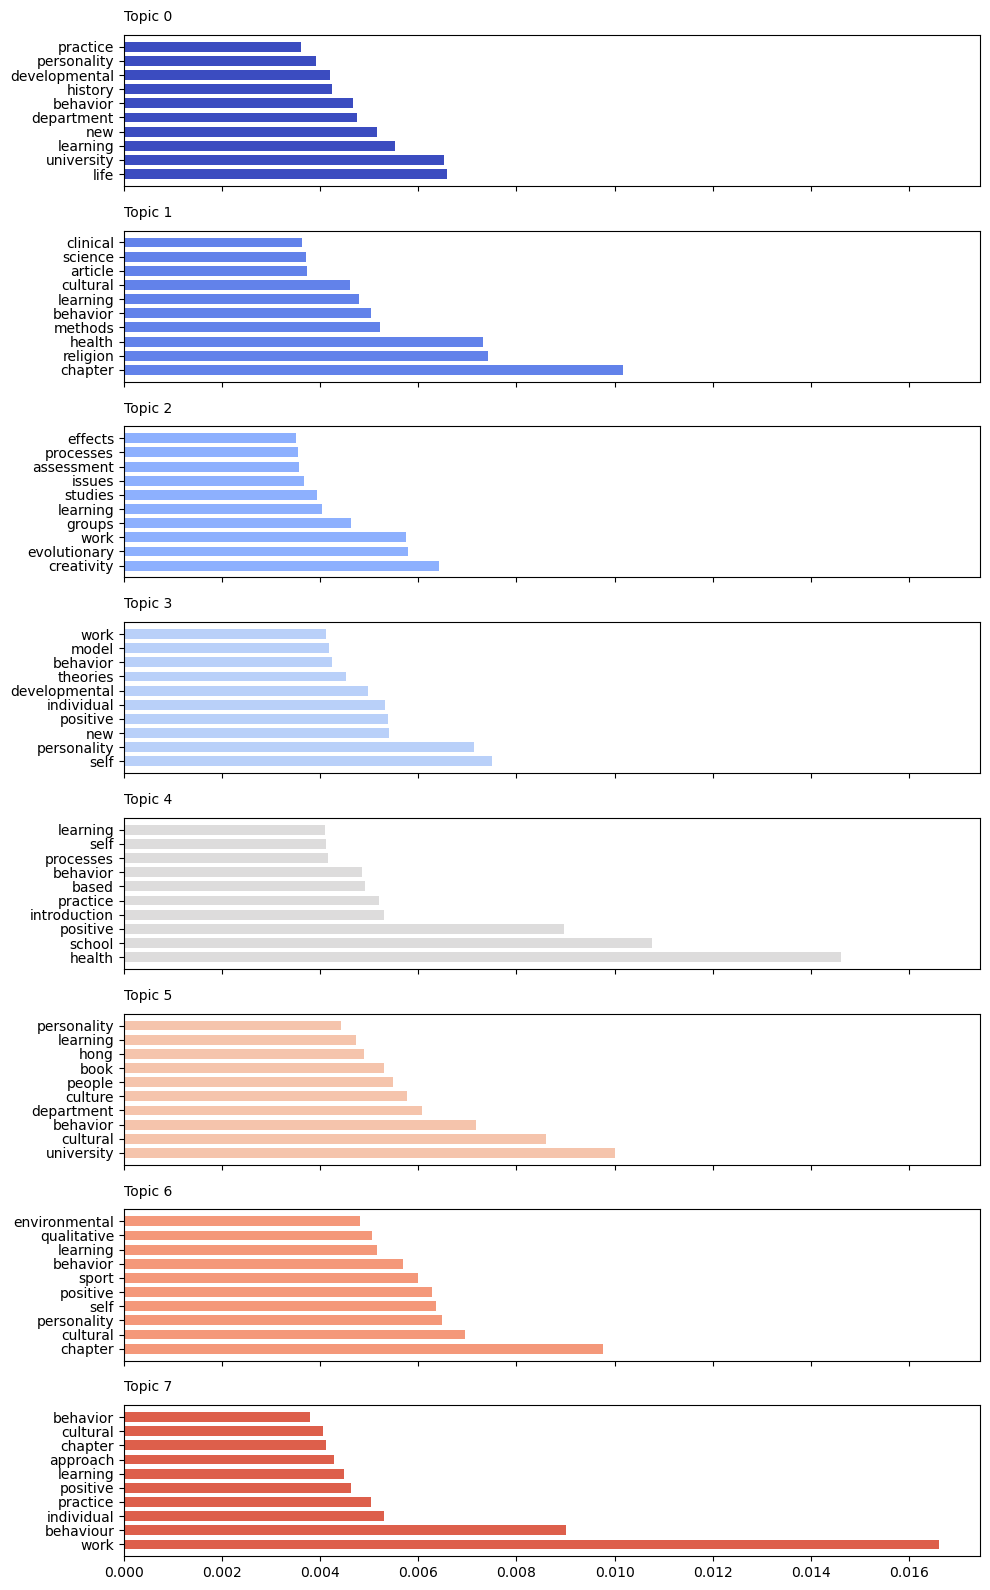

In [111]:
visualize_topic_word_loadings(psychology_senlda, num_words=10)

Systematically vary the $\alpha$, $\eta$, and topic number of the model

In [168]:
# Define a function that returns the lda model and lda dataframe for given num_topics, alpha, eta
def train_lda_prepare_df(corpus, dictionary, reduced_tokens, num_topics=8, alpha='auto', eta='auto'):
    # Train the LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                id2word=dictionary, 
                                                num_topics=num_topics, 
                                                alpha=alpha, 
                                                eta=eta)

    # Prepare the DataFrame with topics
    lda_df = pandas.DataFrame({
        'topics': [lda_model[dictionary.doc2bow(doc)] for doc in reduced_tokens]
    })

    # Dict to temporarily hold the probabilities
    topics_prob_dict = {i: [0] * len(lda_df) for i in range(lda_model.num_topics)}

    # Load them into the dict
    for index, topic_tuples in enumerate(lda_df['topics']):
        for topic_num, prob in topic_tuples:
            # Check if topic_num is within the expected range
            if topic_num in topics_prob_dict:
                topics_prob_dict[topic_num][index] = prob
            else:
                print(f"Unexpected topic number: {topic_num}")

    # Update the DataFrame
    for topic_num in range(lda_model.num_topics):
        lda_df[f'topic_{topic_num}'] = topics_prob_dict[topic_num]

    return lda_model, lda_df


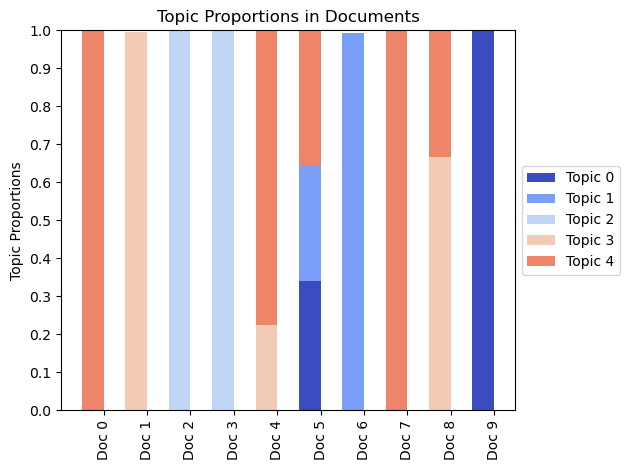

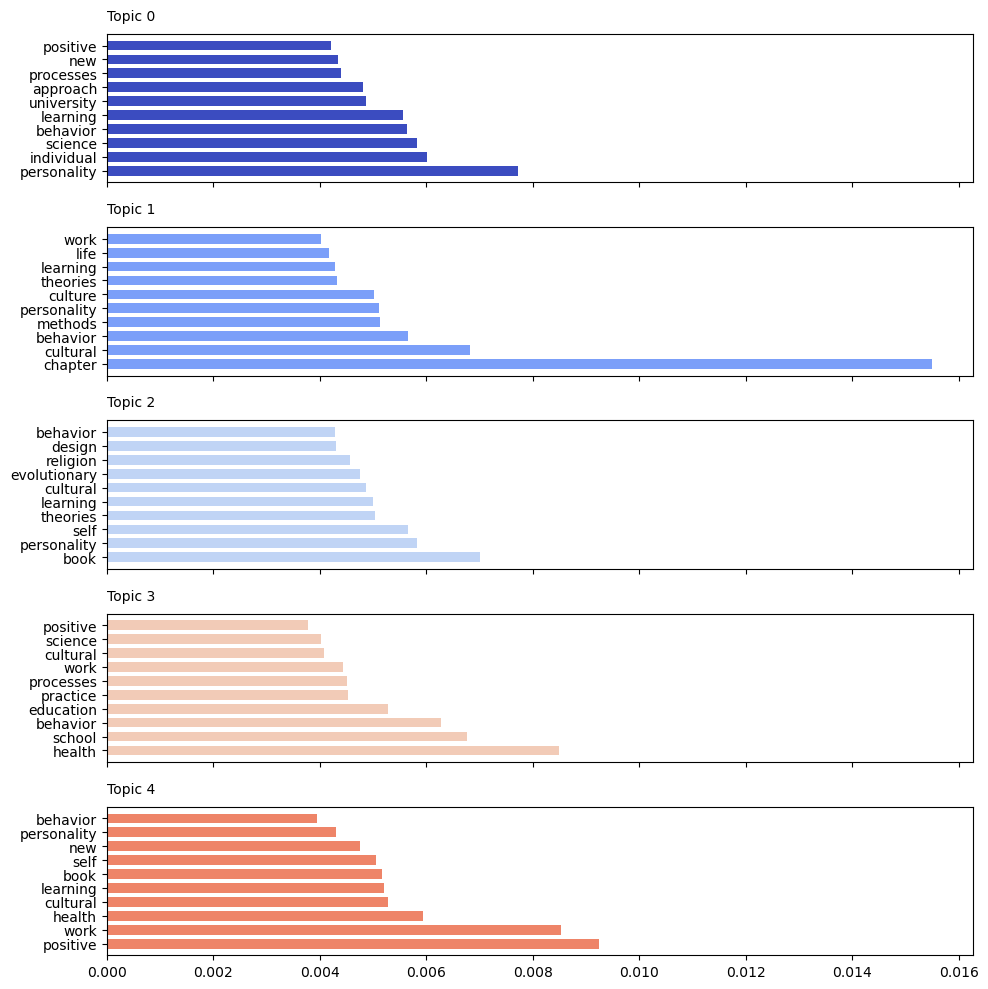

In [170]:
psychology_senlda_1, psychology_ldaDF_1 = train_lda_prepare_df(
    corpus=psychology_senmm,
    dictionary=psychology_dictionary,
    reduced_tokens=psychology_corpus['reduced_tokens'],
    num_topics=5,  
    alpha=0.01, 
    eta=0.01 
)
visualize_document_topic_loadings(psychology_senlda_1, psychology_ldaDF_1, N=10)
visualize_topic_word_loadings(psychology_senlda_1, num_words=10)

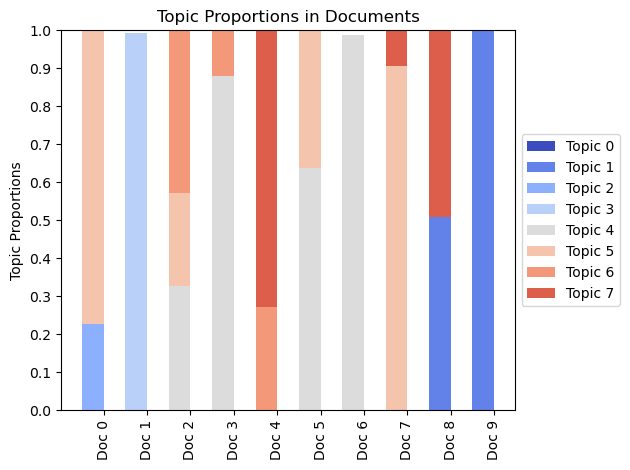

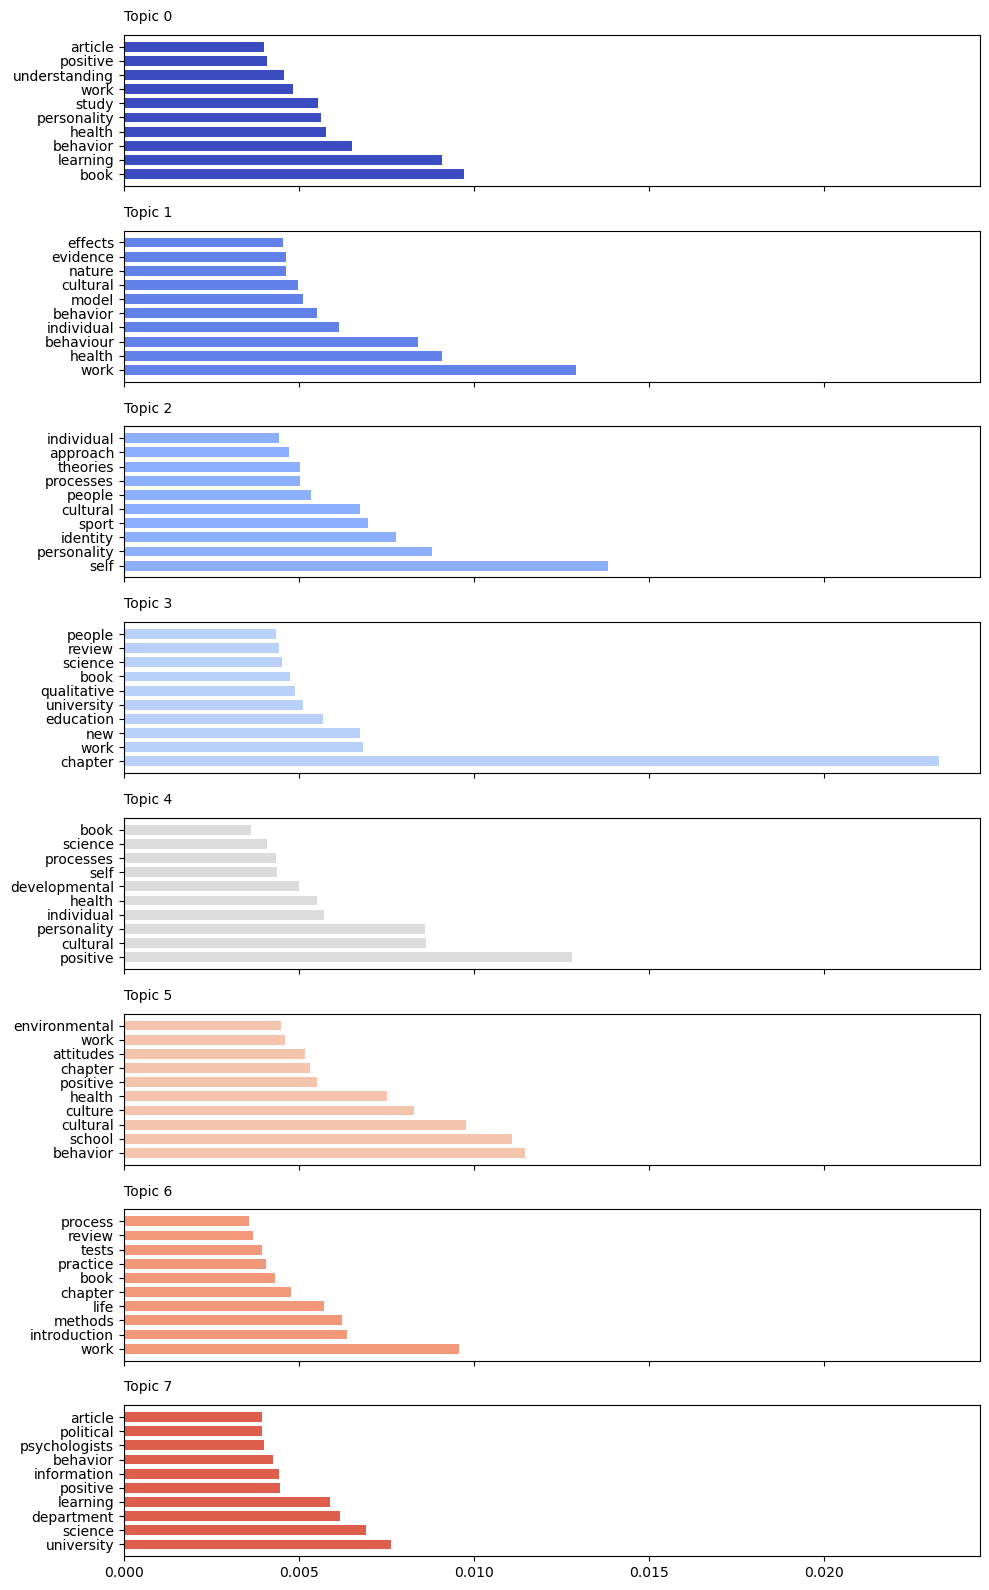

In [172]:
psychology_senlda_2, psychology_ldaDF_2 = train_lda_prepare_df(
    corpus=psychology_senmm,
    dictionary=psychology_dictionary,
    reduced_tokens=psychology_corpus['reduced_tokens'],
    num_topics=8,  
    alpha=0.01, 
    eta=0.01 
)
visualize_document_topic_loadings(psychology_senlda_2, psychology_ldaDF_2, N=10)
visualize_topic_word_loadings(psychology_senlda_2, num_words=10)

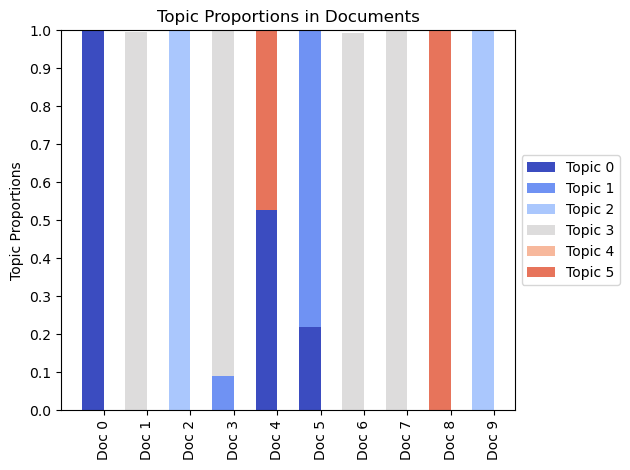

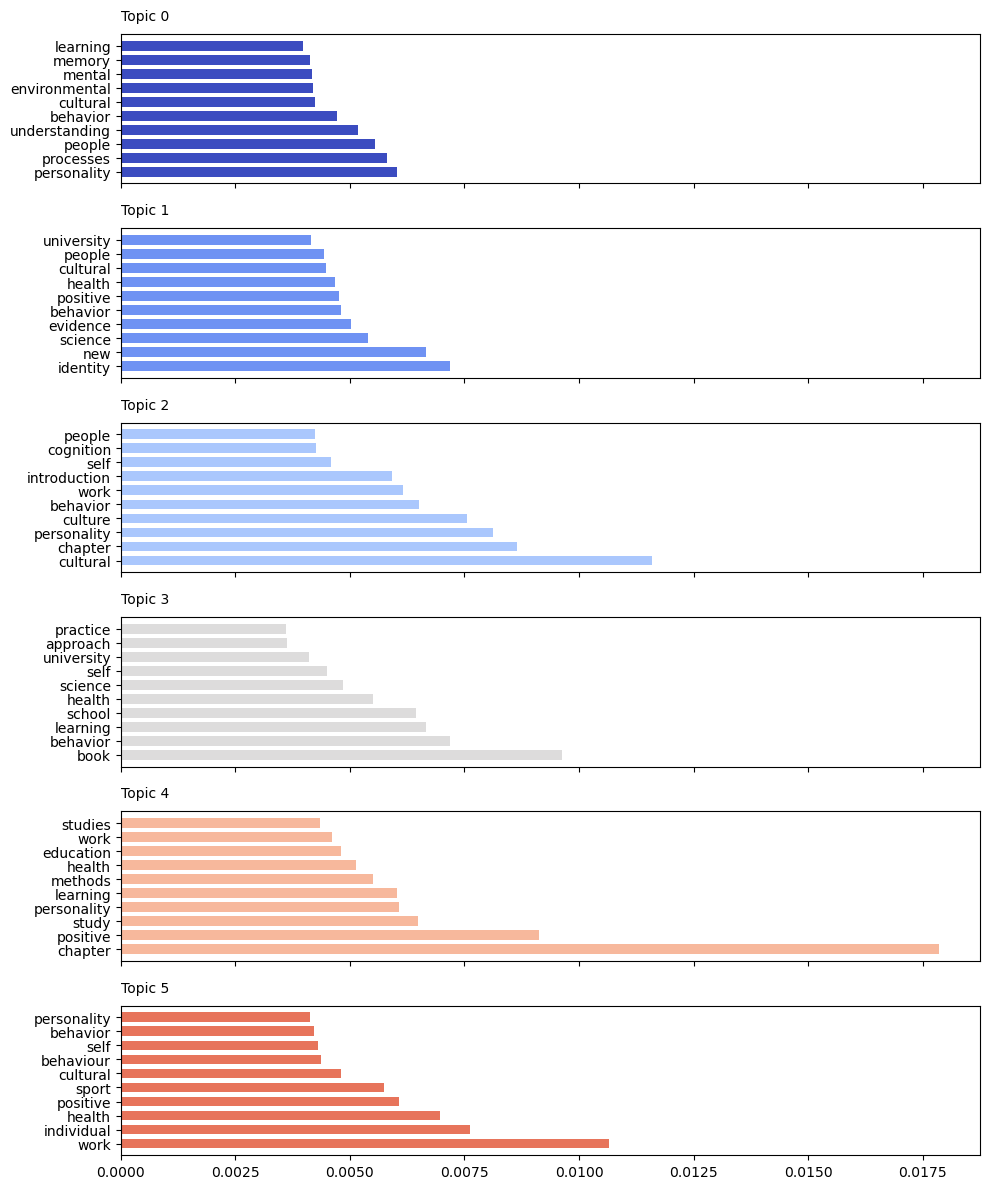

In [173]:
psychology_senlda_3, psychology_ldaDF_3 = train_lda_prepare_df(
    corpus=psychology_senmm,
    dictionary=psychology_dictionary,
    reduced_tokens=psychology_corpus['reduced_tokens'],
    num_topics=6,  
    alpha=0.01, 
    eta=0.01 
)
visualize_document_topic_loadings(psychology_senlda_3, psychology_ldaDF_3, N=10)
visualize_topic_word_loadings(psychology_senlda_3, num_words=10)

To be honest, I think LDA does not give a clear topic strcutre for my mini psychology abrastract corpus, which could be attributed to the small sample size of my corpus as well as the high level of repeated words (such as introduction, behavior, personality; though they indeed carry more meaning compared to, say, stopwords). 

Consequently, I am having trouble interpreting the content of each cluster returned (and how I should name them).

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does. `lucem_illud.loadDavies` can be found in [loaders.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/loaders.py).

In [174]:
# corpora_address = "/Downloads/SOAP"


In [175]:
# soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

In [176]:
# import zipfile
# import pandas as pd

In [177]:
# zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
# source = []

In [178]:
# for file in zfile.namelist():
#     with zfile.open(file) as f:
#         for line in f:
#             source.append(line)

In [179]:
# soap_dict = {}

In [180]:
# for soap in source[3:]:
#     try:
#         textID, year, show, url = soap.decode("utf-8").split("\t")
#     except UnicodeDecodeError:
#         continue
#     if show.strip() not in soap_dict:
#         soap_dict[show.strip()] = []
#     if show.strip() in soap_dict:
#         try:
#             soap_dict[show.strip()].append(soap_texts[textID.strip()])
#         except KeyError:
#             continue

In [181]:
# soap_dict.keys()

In [182]:
# soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [183]:
# i = 0

In [184]:
# for soap in soap_dict:
#     # since there were multiple lists
#     print(soap)
#     full_script = []
#     for part in soap_dict[soap]:
#         full_script = full_script + part
#     soap_df.loc[i] = [soap, full_script]
#     i += 1

In [185]:
# soap_df

Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [186]:
# dool = soap_df['Tokenized Texts'][9]

In [187]:
# ' '.join(dool[0:1500])

In [188]:
# characters = {}
# for token in dool:
#     if token[0] == '@':
#         # all characters or actions start with @, so we add that to character
#         if token[2:] not in characters:
#             characters[token[2:]] = 0
#         if token[2:] in characters:
#             characters[token[2:]] += 1

In [189]:
# import networkx as nx

In [190]:
# actor_network = nx.Graph()

In [191]:
# for character in characters:
#     if characters[character] > 2000:
#         actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [192]:
# i = 0

In [193]:
# all_texts = []

In [194]:
# for token in dool:
#     i += 1
#     if i > len(dool):
#         break
#     if token[0] == "@":
#         if token[2:] in actor_network.nodes():
#             j = i
#             for token_ in dool[i:]:
#                 if token_[0] == "@":
#                     # if both the characters exist in the graph, add a weight
#                     if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
#                         if (token[2:], token_[2:]) not in actor_network.edges():
#                             actor_network.add_edge(token[2:], token_[2:], weight=0)
#                         if (token[2:], token_[2:]) in actor_network.edges():
#                             actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
#                     break
#                 j += 1
#             # adding characters sentences
#             actor_network.nodes[token[2:]]['words'].append(dool[i:j])
#             all_texts.append(lucem_illud.normalizeTokens(dool[i:j]))

In [195]:
# nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [196]:
# all_texts[0:10]

In [197]:
# dictionary = gensim.corpora.Dictionary(all_texts)

In [198]:
# corpus = [dictionary.doc2bow(text) for text in all_texts]

In [199]:
# gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
# doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [200]:
# doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [201]:
# doollda.show_topics()

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [202]:
# for actor in actor_network.nodes():
#     actor_all_words = []
#     for sent in actor_network.nodes[actor]['words']:
#         for word in sent:
#             actor_all_words += word
#     actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about.

In [203]:
# for actor in actor_network.nodes():
#     print(actor, actor_network.nodes[actor]['topic_distribution'])

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally.

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [204]:
from gensim.matutils import kullback_leibler

In [205]:
# def convert_to_prob(bow):
#     ps = []
#     for topic_no, topic_prob in bow:
#         ps.append(topic_prob)
#     return ps

In [206]:
# L = []
# for actor_1 in actor_network.nodes():
#     p = actor_network.nodes[actor_1]['topic_distribution']
#     p = convert_to_prob(p)
#     l = []
#     for actor_2 in actor_network.nodes():
#         q = actor_network.nodes[actor_2]['topic_distribution']
#         q = convert_to_prob(q)
#         l.append(kullback_leibler(p, q))
#     L.append(l)
# M = np.array(L)

In [207]:
# fig = plt.figure()
# div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
# ax = sns.heatmap(div)
# plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/.


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about.

(An acknowledgement - Bhargav (the author of most of this class's code) wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [208]:
# corpora_address = "/Downloads/COHA"

In [209]:
# coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

In [210]:
# list(coha_texts.keys())[0:5]

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts, and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [211]:
# coha_genres = {}
# coha_years = {}

In [212]:
# for article in coha_texts:
#     genre, year, id_ = article.split("_")
#     if genre not in coha_genres:
#         coha_genres[genre] = []
#     if genre in coha_genres:
#         coha_genres[genre].append(coha_texts[article])

#     if year not in coha_years:
#         coha_years[year] = []
#     if year in coha_years:
#         coha_years[year].append(coha_texts[article])

In [213]:
# coha_genres.keys()

In [214]:
# coha_years.keys()

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [215]:
import collections

In [216]:
# years = []
# year_lens = []

In [217]:
# for year_info in collections.OrderedDict(sorted(coha_years.items())):
#     years.append(year_info)
#     year_lens.append(len((coha_years[year_info])))

In [218]:
# years[0], years[-1]

In [219]:
# import matplotlib.pyplot as plt
# plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [220]:
# all_texts_coha = []
# docs_per_timeslice = [0, 0, 0, 0, 0]
# i = 0

In [221]:
# for year_info in collections.OrderedDict(sorted(coha_years.items())):
#     large_files = 0
#     for article in coha_years[year_info]:
#         try:
#             if len(article[2]) < 1500000:
#                 all_texts_coha.append(lucem_illud.normalizeTokens(article[2].decode("utf-8")))
#             if len(article[2]) >= 1500000:
#                 large_files += 1
#         except IndexError:
#             continue
#     # these numbers are the number of years in the
#     if i < 70:
#         docs_per_timeslice[0] += len(coha_years[year_info]) - large_files
#     if i >= 70 and i < 103:
#         docs_per_timeslice[1] += len(coha_years[year_info]) - large_files
#     if i >= 103 and i < 140:
#         docs_per_timeslice[2] += len(coha_years[year_info]) - large_files
#     if i >= 140 and i < 180:
#         docs_per_timeslice[3] += len(coha_years[year_info]) - large_files
#     if i >= 180:
#         docs_per_timeslice[4] += len(coha_years[year_info]) - large_files
#     i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [222]:
# def choose_n(corpus, time_slices, nums=100):
#     new_corpus = corpus[0:nums]
#     for time_slice in time_slices[:-1]:
#         new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
#     return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [223]:
# def split_up(document, doc_size=1000):
#     new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
#     return(new_docs, len(new_docs))

In [224]:
# small_corpus = choose_n(all_texts_coha, docs_per_timeslice, nums=100)

In [225]:
# final_corpus= []

In [226]:
# docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice.

In [227]:
# for i, article in enumerate(small_corpus):
#     # identify time slice based on article number
#     if i < 100:
#         time = 0
#     if i > 100 and i <= 200:
#         time = 1
#     if i > 200 and i <= 300:
#         time = 2
#     if i > 300 and i <= 400:
#         time = 3
#     if i > 400 and i <= 500:
#         time = 4

#     if len(article) > 1000:
#         split_docs, no_docs = split_up(article)
#         for doc in split_docs:
#             final_corpus.append(doc)
#         docs_per_time_slice[time] += no_docs
#     else:
#         final_corpus.append(article)
#         docs_per_time_slice[time] += 1
#     # just a check if the counts are correctly added
#     if np.sum(docs_per_time_slice) != len(final_corpus):
#         print(np.sum(docs_per_time_slice), len(final_corpus))

In [228]:
# dictionary = gensim.corpora.Dictionary(final_corpus)

In [229]:
# corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [230]:
# gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
# cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [231]:
# from gensim.models import ldaseqmodel

In [232]:
# ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [233]:
# ldaseq.print_topics(time=0)[1]

In [234]:
# ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [235]:
# ldaseq.save("ldaseqmodel")

In [236]:
# loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")

For future research, you can also consider the Structural Topic Model (STM), which can integrate any covariates (e.g., time, author, document length) into your topic model. Unfortunately there is not yet an implementation of this in Python, but there is a wonderful [R package](https://www.structuraltopicmodel.com/) authored by Molly Roberts, Brandon Stewart, and Dustin Tingley.

Here are plate diagrams of LDA and STM, which may help you visualize the way STM adds covariates to the "left" and "right" of the standard LDA model.

<img src="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-3/img/lda_stm_plate_diagrams.jpg" alt="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-3/img/lda_stm_plate_diagrams.jpg" style="width:500px">



## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that use dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

For this exercise, I choose to consrtuct the psychology abstract corpus of 5 time points each with a 5-year interval from 2023:

In [238]:
import time
import requests
import random
import pandas

def scrape_abstract_updated(fieldsOfStudy, year, limit_per_field=600, 
                            url='https://api.semanticscholar.org/graph/v1/paper/search'):

    headers = {"x-api-key": "KOyXiGdu4t38zFJFFyuKF5jQGBGdxCSfDICseepg"}
    
    all_data = []

    # Start with no offset
    offset = 0
    total_papers = 0

    while total_papers < limit_per_field:
        query_params = {
            'year': year,
            'query': fieldsOfStudy,
            'fields': 'title,authors,abstract',
            'limit': 100,  # This is typically the max the API allows per request
            'offset': offset
        }

        response = requests.get(url, headers=headers, params=query_params)

        if response.status_code == 200:
            papers = response.json().get('data', [])
            
            # Break the loop if no papers are returned
            if not papers:
                break

            for paper in papers:
                title = paper.get('title')
                author = paper.get('authors')
                abstract = paper.get('abstract')

                if not title or not author or not abstract:
                    continue

                author_names = ', '.join([a['name'] for a in author])

                all_data.append({
                    "Year": year,
                    "FieldOfStudy": fieldsOfStudy,
                    "Title": title,
                    "Author": author_names,
                    "Abstract": abstract})

                total_papers += 1

                # Break the loop if we have reached the limit
                if total_papers >= limit_per_field:
                    break

        else:
            print(f"Request failed with status code {response.status_code}")
            break

        # Increase the offset for the next loop iteration
        offset += len(papers)

        # Sleep to respect rate limits
        sleep_time = random.randint(1,3)
        time.sleep(sleep_time)

    df = pandas.DataFrame(all_data)

    return df

In [239]:
years = [2003, 2008, 2013, 2018, 2023] 
fieldsOfStudy = "Psychology"

all_years_data = []

for year in years:
    df_year = scrape_abstract_updated(fieldsOfStudy, year)
    all_years_data.append(df_year)

# Combine all dataframes
psychology_corpus_long = pandas.concat(all_years_data, ignore_index=True)

# If you want to sort the final dataframe by year
psychology_corpus_long = psychology_corpus_long.sort_values(by='Year').\
    reset_index(drop=True)

psychology_corpus_long

Year FieldOfStudy                                              Title  \
0     2003   Psychology  Maps of Bounded Rationality: Psychology for Be...   
1     2003   Psychology  A review of life satisfaction research with ch...   
2     2003   Psychology  Does father absence place daughters at special...   
3     2003   Psychology                         The Psychology of the Body   
4     2003   Psychology  Validation of the Female Sexual Function Index...   
...    ...          ...                                                ...   
2995  2023   Psychology  Corrigendum: Advances on self-regulation model...   
2996  2023   Psychology  Unlocking the Psychology of Work and Insecurit...   
2997  2023   Psychology  An Evaluation of Cognitive Behavioral Therapy ...   
2998  2023   Psychology  Theory, Methods, and Practice to Advance Equit...   
2999  2023   Psychology  EXPRESS: The Influence of the Design of Mental...   

                                                 Author  \
0                                           D. Kahneman   
1                                 R. Gilman, S. Huebner   
2     B. Ellis, J. Bates, K. Dodge, D. Fergusson, L....   
3                      E. Greene, Barbara Goodrich-Dunn   
4                                             C. Meston   
...                                                 ...   
2995  J. de la Fuente, J. M. Martínez-Vicente, Flávi...   
2996                                     Gabriel C Kanu   
2997  Cassandra L. Boness, V. Votaw, Frank J. Schweb...   
2998  Amanda L. Sullivan, Prerna G. Arora, Sam Song,...   
2999                           Leonardo Jost, P. Jansen   

                                               Abstract  
0     The work cited by the Nobel committee was done...  
1     An important construct in positive psychology ...  
2     The impact of father absence on early sexual a...  
3     Section I: The Body Organizes Experience1. The...  
4     Department of Psychology, University of Texas ...  
...                                                 ...  
2995  [This corrects the article DOI: 10.3389/fpsyg....  
2996  Because of Nigeria’s growing security problems...  
2997  Cognitive behavioral therapy (CBT) is a common...  
2998  Abstract In recent years, school psychology ha...  
2999  Sex differences in mental rotation performance...  

[3000 rows x 5 columns]

In [8]:
import lucem_illud
import gensim
from collections import Counter
import sklearn

senTFVectorizer_psychology_long = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects_long = senTFVectorizer_psychology_long.fit_transform(psychology_corpus_long["Abstract"])

psychology_corpus_long['tokenized_text'] = psychology_corpus_long["Abstract"].apply(lambda x: lucem_illud.word_tokenize(x))
psychology_corpus_long['normalized_tokens'] = psychology_corpus_long['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))
psychology_corpus_long['reduced_tokens'] = psychology_corpus_long['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer_psychology_long.vocabulary_.keys()))

psychology_dictionary_long = gensim.corpora.Dictionary(psychology_corpus_long['reduced_tokens'])

# Serialize the corpus
gensim.corpora.MmCorpus.serialize('abstract_long.mm', [psychology_dictionary_long.doc2bow(text) for text in psychology_corpus_long['reduced_tokens']])
psychology_senmm_long = gensim.corpora.MmCorpus('abstract_long.mm')

# Prepare time slices
abstracts_per_year = Counter(psychology_corpus_long['Year'])
time_slices = [abstracts_per_year[year] for year in sorted(abstracts_per_year)]

ldaseq = gensim.models.LdaSeqModel(corpus=psychology_senmm_long, id2word=psychology_dictionary_long, time_slice=time_slices, num_topics=8)

/Users/samcong/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/Users/samcong/anaconda3/lib/python3.11/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/samcong/anaconda3/lib/python3.11/site-packages/gensim/models/ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
/Users/samcong/anaconda3/lib/python3.11/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/samcong/anaconda3

In [9]:
# Initialize an empty list to collect dictionaries
data_dicts = []

# Calculate the cumulative sum of documents up to each time slice to get the correct document IDs
doc_id_offset = 0

# Iterate over each time slice
for time_slice, num_docs in enumerate(time_slices):
    # Iterate over each document in the time slice
    for doc_num_within_slice in range(num_docs):
        # Calculate the actual document ID based on the time slice
        doc_id = doc_id_offset + doc_num_within_slice
        
        # Get the topic distribution for the current document
        doc_topics = ldaseq.doc_topics(doc_id)
        doc_topics = doc_topics.tolist()
    
        # Create a dictionary for the current document
        doc_dict = {
            'Year': years[time_slice],
            'Doc_ID': doc_id
        }
        
        # Add each topic's probability to the dictionary
        for topic_num, topic_prob in enumerate(doc_topics):
            doc_dict['Topic_{}'.format(topic_num)] = topic_prob
        
        # Append the dictionary to the list
        data_dicts.append(doc_dict)
    
    # Update the document ID offset
    doc_id_offset += num_docs

# Convert the list of dictionaries to a DataFrame
psychology_ldaDF_dynamic = pandas.DataFrame(data_dicts)

psychology_ldaDF_dynamic


Year  Doc_ID   Topic_0   Topic_1   Topic_2   Topic_3   Topic_4  \
0     2003       0  0.368806  0.019357  0.000250  0.183564  0.000250   
1     2003       1  0.001238  0.001238  0.413179  0.473789  0.001238   
2     2003       2  0.000159  0.023078  0.556439  0.419691  0.000159   
3     2003       3  0.040314  0.000222  0.181028  0.000222  0.000222   
4     2003       4  0.000415  0.000415  0.045068  0.314234  0.638621   
...    ...     ...       ...       ...       ...       ...       ...   
2995  2023    2995  0.000524  0.000524  0.313561  0.683295  0.000524   
2996  2023    2996  0.126570  0.000159  0.039090  0.365204  0.000159   
2997  2023    2997  0.000263  0.418664  0.000263  0.455168  0.000263   
2998  2023    2998  0.000622  0.000622  0.000622  0.995647  0.000622   
2999  2023    2999  0.087218  0.000185  0.000185  0.093102  0.190079   

       Topic_5   Topic_6   Topic_7  
0     0.000250  0.000250  0.427275  
1     0.001238  0.001238  0.106844  
2     0.000159  0.000159  0.000159  
3     0.722360  0.055410  0.000222  
4     0.000415  0.000415  0.000415  
...        ...       ...       ...  
2995  0.000524  0.000524  0.000524  
2996  0.278856  0.000159  0.189805  
2997  0.000263  0.000263  0.124855  
2998  0.000622  0.000622  0.000622  
2999  0.489463  0.080918  0.058851  

[3000 rows x 10 columns]

Extract Top 10 Words for Each Topic from the Model:

In [11]:
num_topics = ldaseq.num_topics
num_words = 10

topic_words = {}
for topic_num in range(num_topics):
    topic_words[topic_num] = {}
    words_probs = ldaseq.print_topic_times(topic_num)  # Get top words for the topic at each time slice
    
    for time_slice, words_prob in enumerate(words_probs):
        year = years[time_slice]
        topic_words[topic_num][year] = [(word, round(prob, 4)) for word, prob in words_prob[:num_words]]


# Create a DataFrame to show the results
top_words_df  = []

for topic_num, topics_over_time in topic_words.items():
    for year, words_probs in topics_over_time.items():
        for word, prob in words_probs:
            top_words_df.append({
                'Topic': topic_num,
                'Year': year,
                'Word': word,
                'Probability': prob
            })

# Create DataFrame
top_words_df = pandas.DataFrame(top_words_df)

top_words_df

Topic  Year        Word  Probability
0        0  2003    consumer       0.0039
1        0  2003  humanistic       0.0031
2        0  2003      visual       0.0029
3        0  2003  ecological       0.0029
4        0  2003  processing       0.0027
..     ...   ...         ...          ...
395      7  2023   countries       0.0042
396      7  2023     beliefs       0.0040
397      7  2023      global       0.0038
398      7  2023     sharing       0.0035
399      7  2023    literacy       0.0032

[400 rows x 4 columns]

Visualize the result in a heatmap:

In [13]:
def plot_topic_heatmap(topic_number):
    # Filter the DataFrame for the specific topic
    filtered_df = top_words_df[top_words_df['Topic'] == topic_number]
    
    # Pivot the filtered DataFrame to get the right format for the heatmap
    heatmap_df = filtered_df.pivot_table(values='Probability', index='Word', columns='Year', fill_value=0)

    # Sort by the sum of probabilities across all years to get the most significant words on top
    heatmap_df = heatmap_df.sort_values(by=heatmap_df.columns.to_list(), ascending=False)

    # Creating the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(heatmap_df, cmap='YlGnBu')
    plt.title(f'Word Probabilities Over Time for Topic {topic_number}')
    plt.ylabel('Words')
    plt.xlabel('Year')
    plt.show()

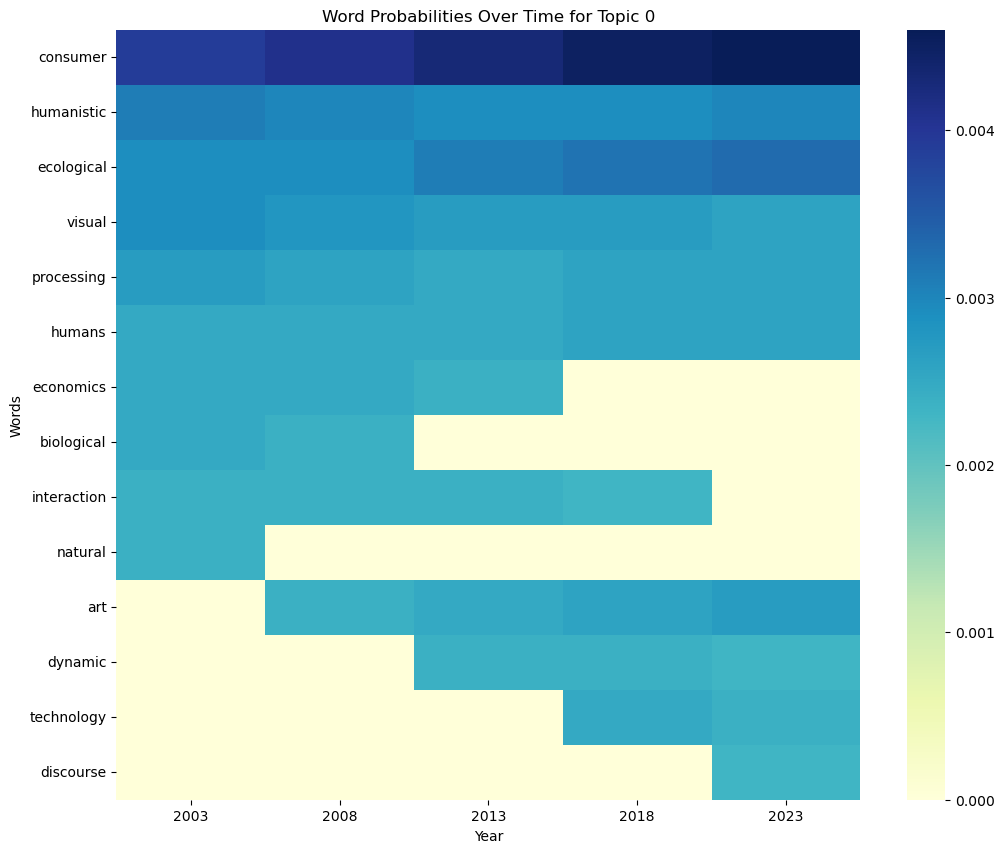

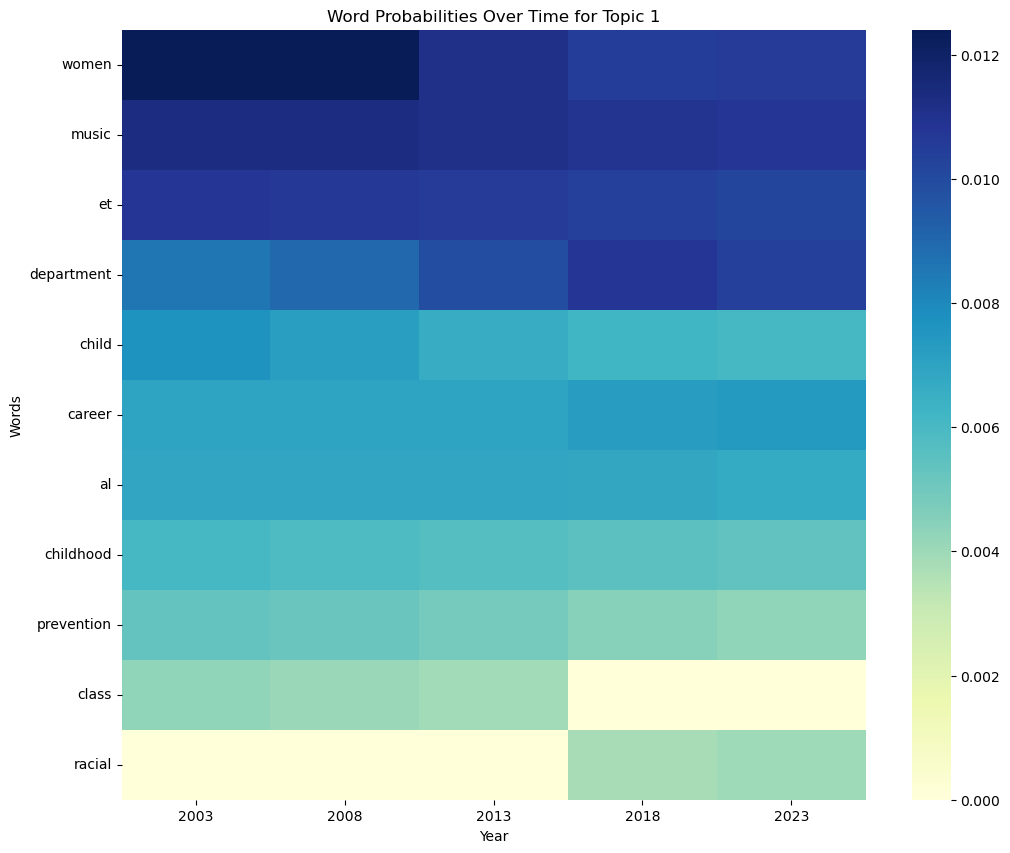

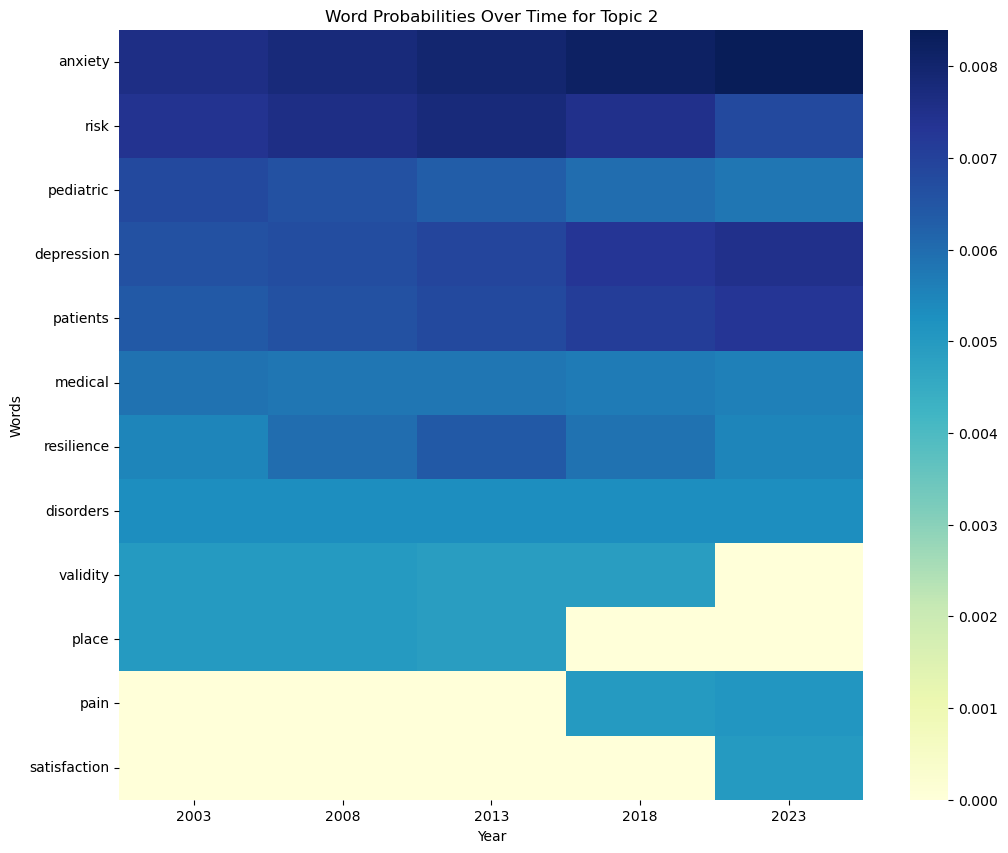

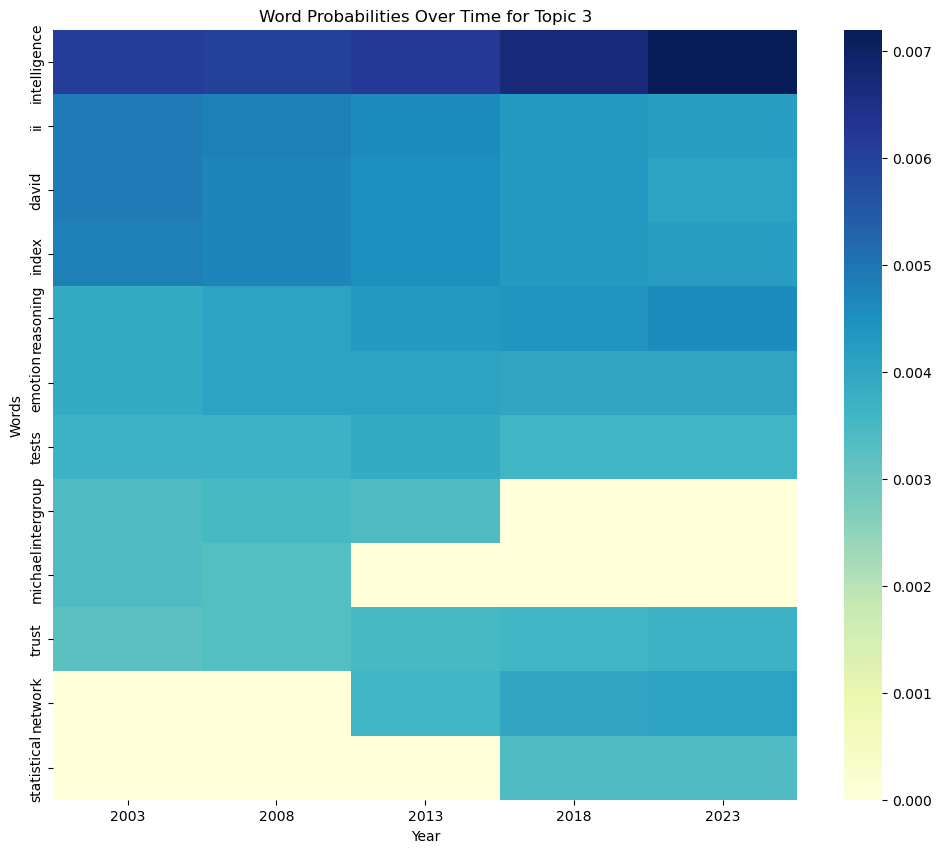

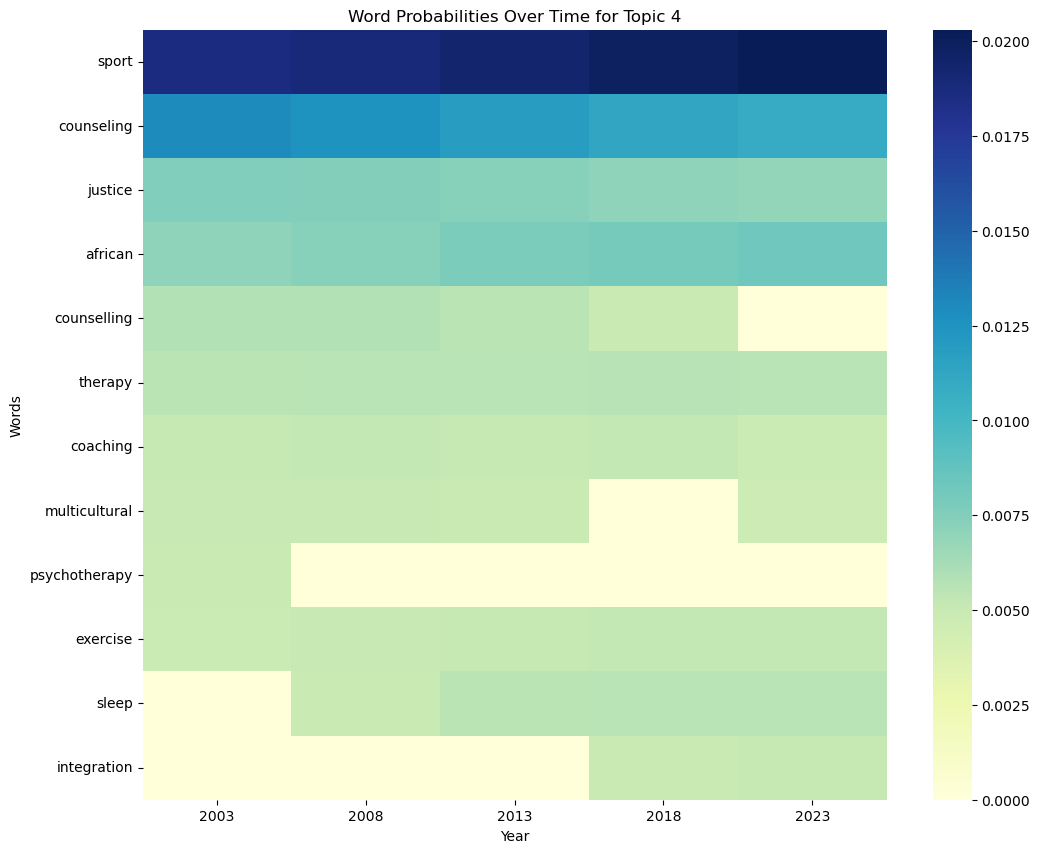

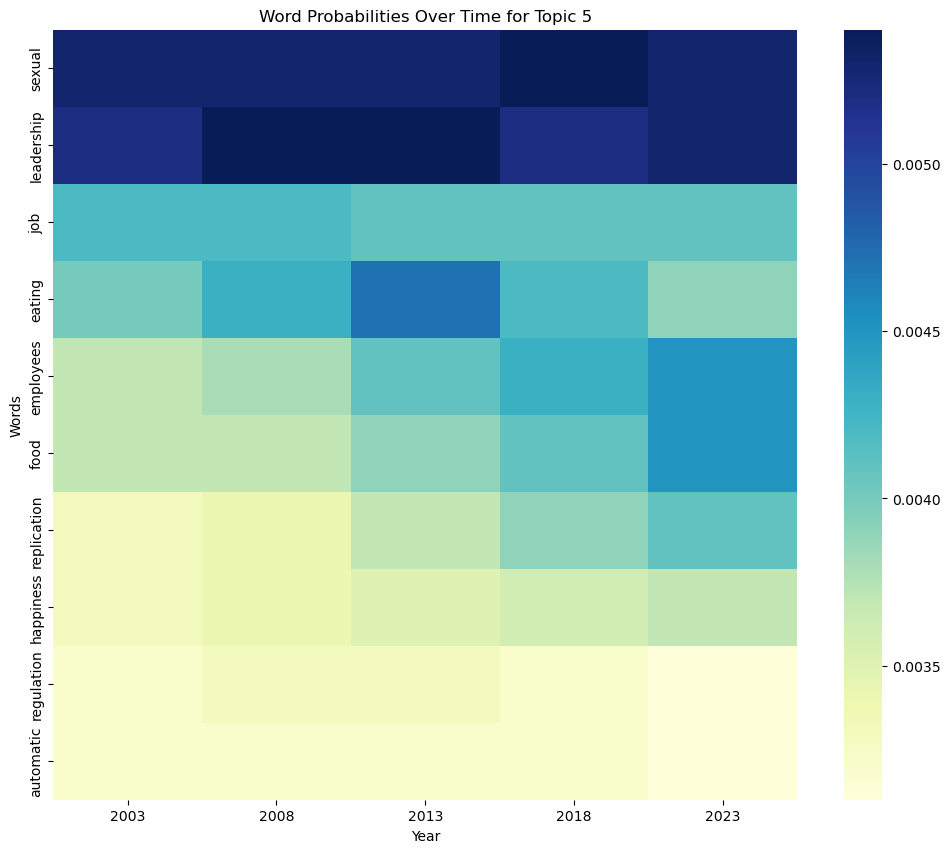

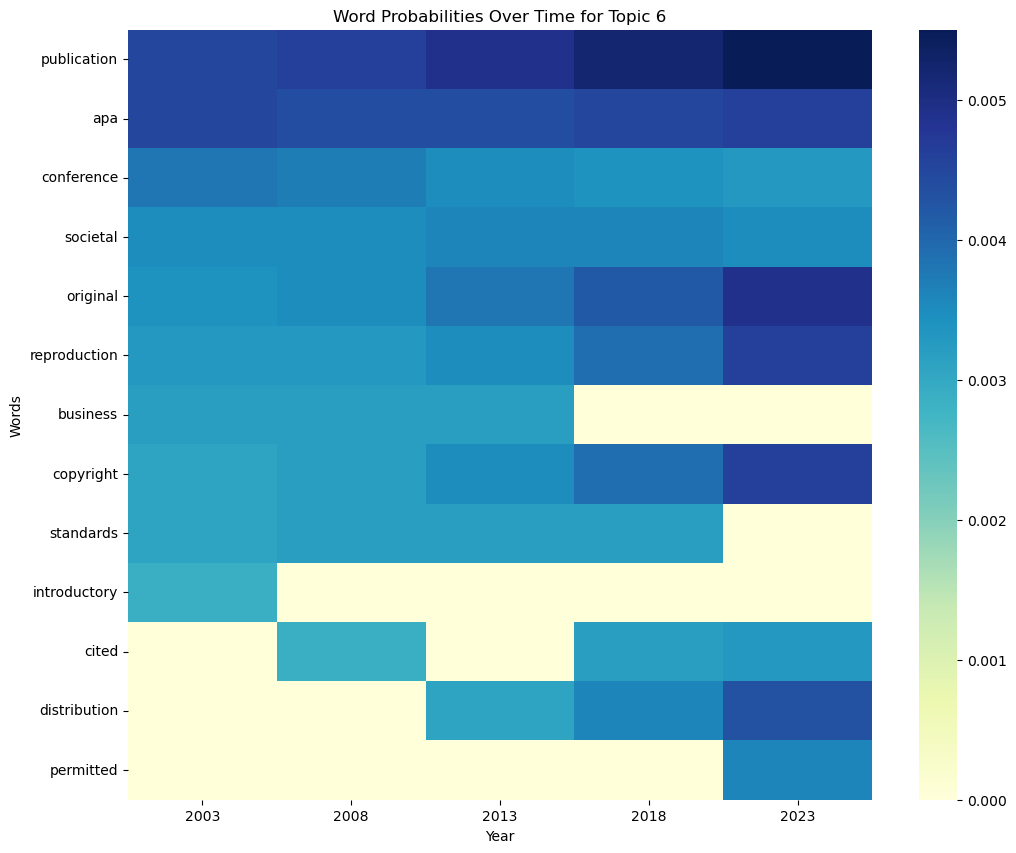

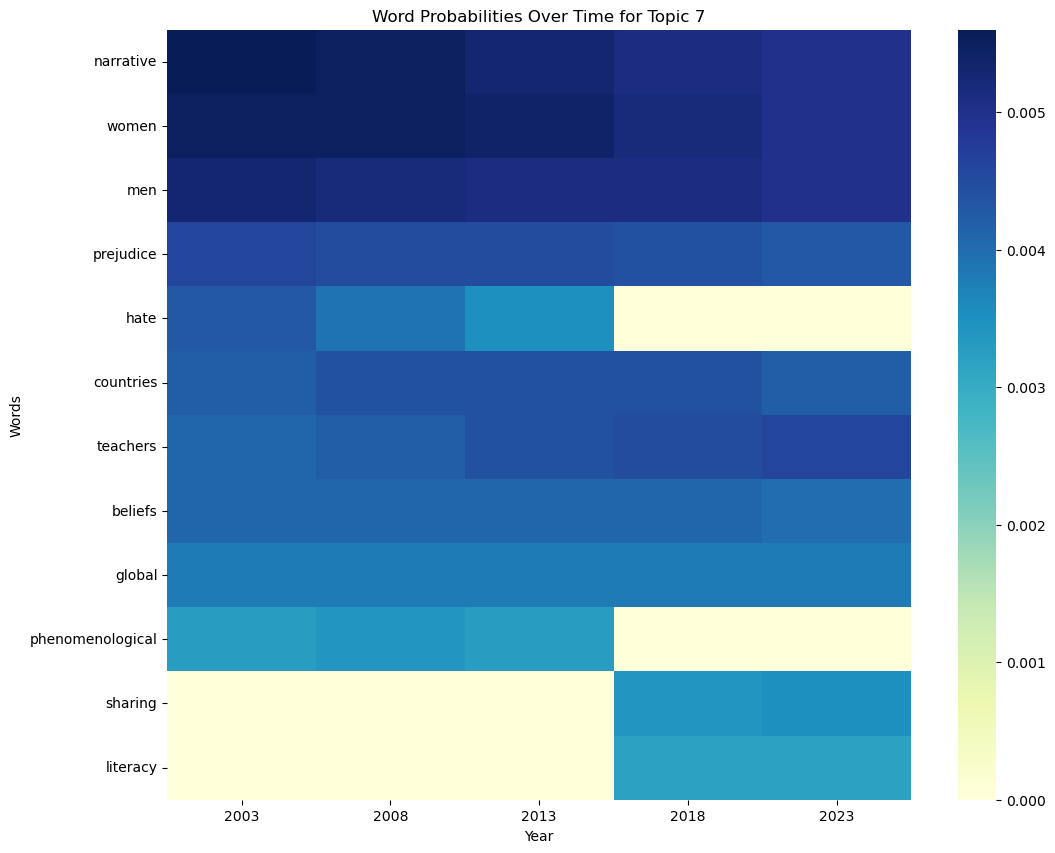

In [15]:
for i in range(8):
    plot_topic_heatmap(i)

Dynamic topic modeling gives a better picture of changes in (common) word usage and, furthermore, area of study in psychology abstract. 

We can see words that are growing in importance such as statistical, network, distribution, employees, pain, and racial. On the other hand, we can see topics that are decreasing in importance such as phenomenological, psychotherapy, validity, and natural.